In [65]:
import geopandas as gpd
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import rioxarray as rxr
from scipy import stats, interpolate
from statsmodels.distributions.empirical_distribution import ECDF
import datetime as dt
from scipy.stats import norm
from copulae import GaussianCopula, ClaytonCopula, FrankCopula, GumbelCopula, StudentCopula # Using Copulae Module
import seaborn as sns
from scipy.stats import kendalltau

# Import helper function
import helper_functions

In [5]:
# Set dataset dir

dataset = '../../datasets/'
et = os.path.join(dataset, 'et/gha_lsa_et.nc')
precipitation = os.path.join(dataset, 'precipitation_chirps/precip_chirps_gha.nc')
tws = os.path.join(dataset, 'gha_tws.nc')
water_mask = os.path.join(dataset, 'water_mask/water_body.shp')
# landform = os.path.join(dataset, 'landform/landform.tif')

In [ ]:
# Open and display

et_data = xr.open_dataset(et)['ET']

precipitation_data = xr.open_dataset(precipitation)['precipitation']

tws_data = xr.open_dataset(tws)['twsddk']

# Load the landform GeoTIFF
landform_data = rxr.open_rasterio(landform)

In [7]:
# Select the time to start from 2004
tws_data = tws_data.sel(time=slice('2004-01-01', None))

# Convert units: tws (m) to mm
tws_data = tws_data * 1000 

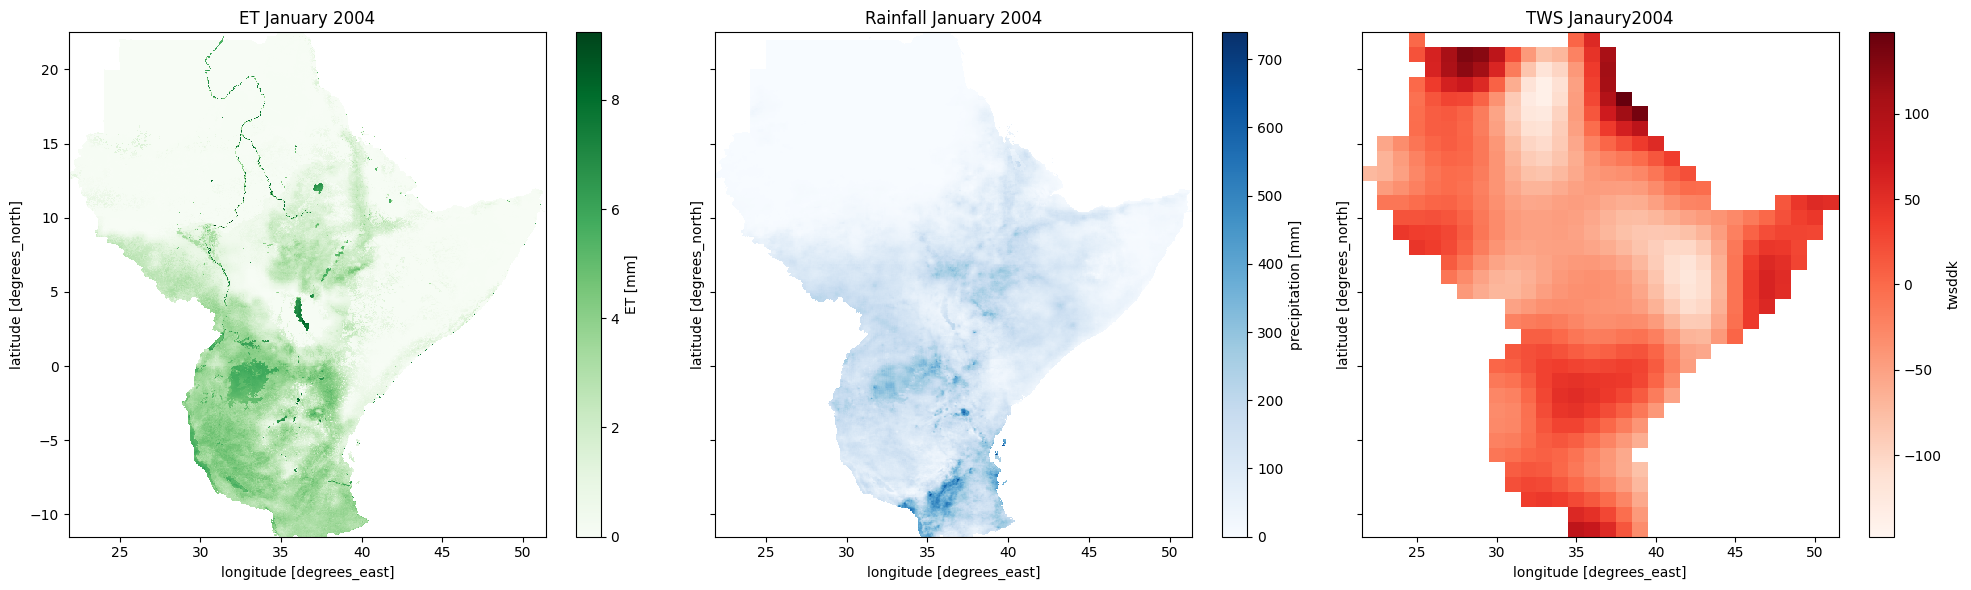

In [5]:
et1 = et_data.isel(time=0)
precip1 = precipitation_data.isel(time=0)
tws1 = tws_data.isel(time=0)

# Set up the figure and axes (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)


# Plot ET
et1.plot(ax=axes[0], cmap="Greens", add_colorbar=True)
axes[0].set_title("ET January {}".format(et1.time.dt.year.values))

# Plot Rainfall
precip1.plot(ax=axes[1], cmap="Blues", add_colorbar=True)
axes[1].set_title("Rainfall January {}".format(precip1.time.dt.year.values))

# Plot TWS
tws1.plot(ax=axes[2], cmap="Reds", add_colorbar=True)
axes[2].set_title("TWS Janaury{}".format(tws1.time.dt.year.values))

plt.tight_layout()
plt.show()

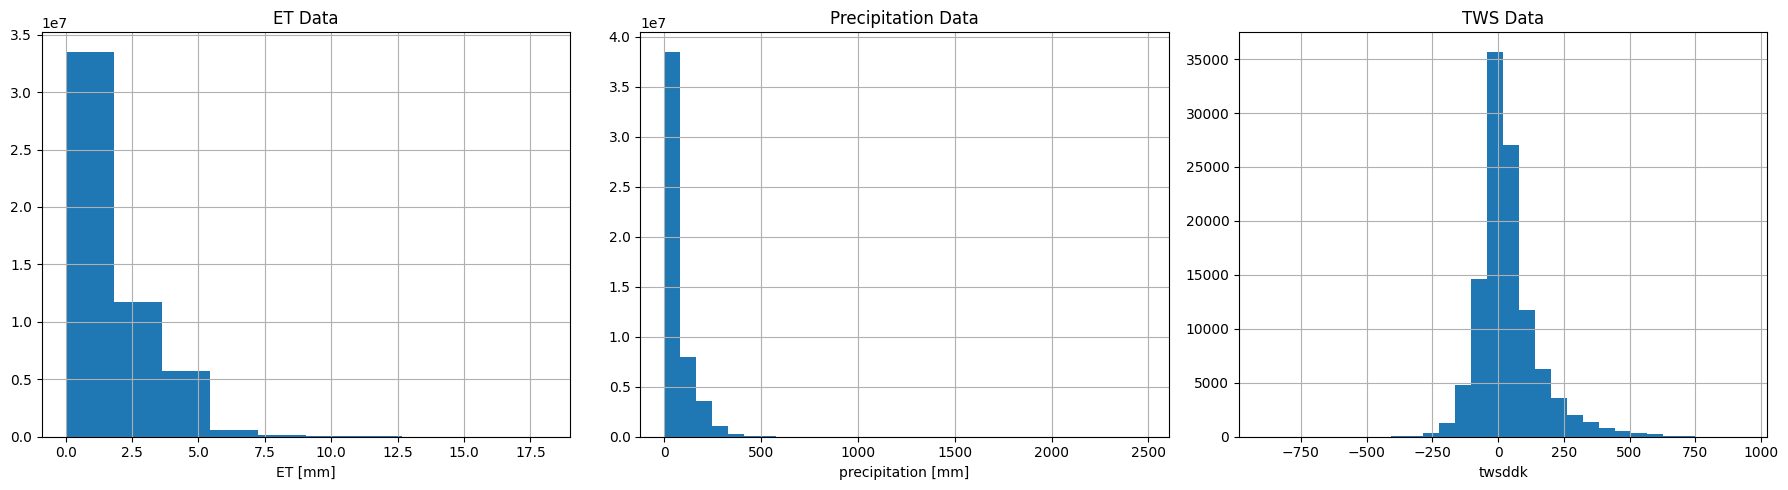

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

et_data.plot.hist(ax=axes[0], bins=10)
axes[0].grid(True)
axes[0].set_title('ET Data')

precipitation_data.plot.hist(ax=axes[1], bins=30)
axes[1].grid(True)
axes[1].set_title('Precipitation Data')

tws_data.plot.hist(ax=axes[2], bins=30)
axes[2].grid(True)
axes[2].set_title('TWS Data')

plt.tight_layout()
plt.show()

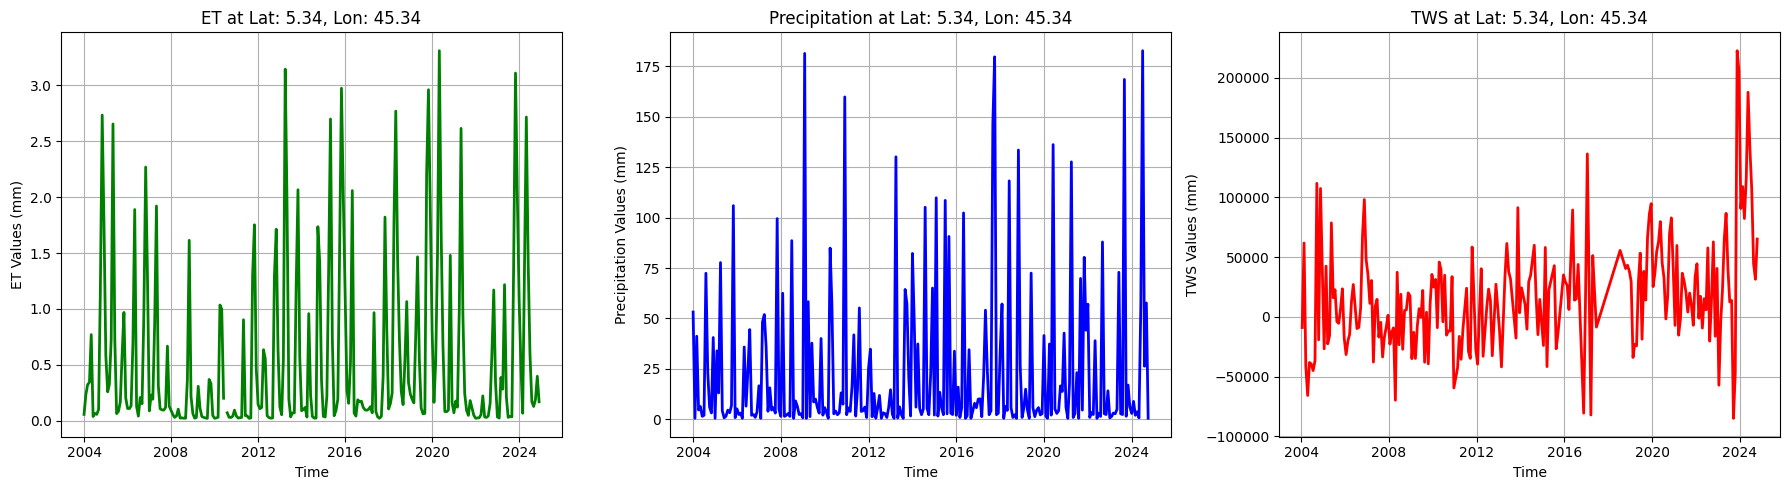

In [8]:
# Variables at a location in GHA

lat = 5.34
lon = 45.34

et_poi = et_data.sel(lat=lat, lon=lon, method='nearest')
pre_poi = precipitation_data.sel(y=lat, x=lon, method='nearest')
tws_poi = tws_data.sel(lat=lat, lon=lon, method='nearest')

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# ET time series
axes[0].plot(et_poi.time, et_poi.values, color='green', linewidth=2)
axes[0].set_title('ET at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[0].set_xlabel('Time', fontsize=10)
axes[0].set_ylabel('ET Values (mm)', fontsize=10)
axes[0].grid(True)

# Precipitation time series
axes[1].plot(pre_poi.time, pre_poi.values, color='blue', linewidth=2)
axes[1].set_title('Precipitation at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[1].set_xlabel('Time', fontsize=10)
axes[1].set_ylabel('Precipitation Values (mm)', fontsize=10)
axes[1].grid(True)

# TWS time series
axes[2].plot(tws_poi.time, tws_poi.values, color='red', linewidth=2)
axes[2].set_title('TWS at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[2].set_xlabel('Time', fontsize=10)
axes[2].set_ylabel('TWS Values (mm)', fontsize=10)
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Variables at a location in GHA

lat = -5.34
lon = 32.34

et_poi = et_data.sel(lat=lat, lon=lon, method='nearest')
pre_poi = precipitation_data.sel(y=lat, x=lon, method='nearest')
tws_poi = tws_data.sel(lat=lat, lon=lon, method='nearest')

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# ET time series
axes[0].plot(et_poi.time, et_poi.values, color='green', linewidth=2)
axes[0].set_title('ET at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[0].set_xlabel('Time', fontsize=10)
axes[0].set_ylabel('ET Values (mm)', fontsize=10)
axes[0].grid(True)

# Precipitation time series
axes[1].plot(pre_poi.time, pre_poi.values, color='blue', linewidth=2)
axes[1].set_title('Precipitation at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[1].set_xlabel('Time', fontsize=10)
axes[1].set_ylabel('Precipitation Values (mm)', fontsize=10)
axes[1].grid(True)

# TWS time series
axes[2].plot(tws_poi.time, tws_poi.values, color='red', linewidth=2)
axes[2].set_title('TWS at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[2].set_xlabel('Time', fontsize=10)
axes[2].set_ylabel('TWS Values (cm)', fontsize=10)
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [16]:
# Merging similar and smaller classes

# Define the reclassification dictionary
reclass_dict = {
    1: 1,   # Plains
    2: 2,   # Mid-altitude plains
    3: 3,   # High-altitude plains
    4: 4,   # Lowlands -> Lowland-Platform-Low Plateau Zone
    5: 4,   # Rugged lowlands -> Lowland-Platform-Low Plateau Zone
    6: 4,   # Platforms -> Lowland-Platform-Low Plateau Zone
    7: 4,   # Low plateaus -> Lowland-Platform-Low Plateau Zone
    8: 5,   # Mid-altitude plateaus -> All Plateaus (Mid-altitude only)
    9: 6,   # High plateaus -> High-Very High Plateaus
    10: 6,  # Very high plateaus -> High-Very High Plateaus
    11: 7,  # Hills -> Hills and Low Mountains
    12: 7,  # Low mountains -> Hills and Low Mountains
    13: 8,  # Mid-altitude mountains
    14: 9,  # High mountains -> All High Mountains
    15: 9   # Very high mountains -> All High Mountains
}

# Apply reclassification
merged_landform_data = landform_data.where(landform_data.isnull(), [reclass_dict.get(x, x) for x in landform_data.values.ravel()]).reshape(landform_data.shape)

# Ensure the data type is appropriate (e.g., int16 or int32)
merged_landform_data = merged_landform_data.astype('int16')

# Update attributes (optional, to reflect the new classification)
merged_landform_data.attrs['description'] = 'Merged Meybeck Landform Classes (9 zones)'
merged_landform_data.attrs['class_mapping'] = str(reclass_dict)

ValueError: operands could not be broadcast together with shapes (1,4188,3550) (1,4188,3550) (14867400,) 

In [22]:
# Define the reclassification dictionary
reclass_dict = {
    1: 1,   # Plains
    2: 2,   # Mid-altitude plains
    3: 3,   # High-altitude plains
    4: 4,   # Lowlands -> Lowland-Platform-Low Plateau Zone
    5: 4,   # Rugged lowlands -> Lowland-Platform-Low Plateau Zone
    6: 4,   # Platforms -> Lowland-Platform-Low Plateau Zone
    7: 4,   # Low plateaus -> Lowland-Platform-Low Plateau Zone
    8: 5,   # Mid-altitude plateaus -> All Plateaus (Mid-altitude only)
    9: 6,   # High plateaus -> High-Very High Plateaus
    10: 6,  # Very high plateaus -> High-Very High Plateaus
    11: 7,  # Hills -> Hills and Low Mountains
    12: 7,  # Low mountains -> Hills and Low Mountains
    13: 8,  # Mid-altitude mountains
    14: 9,  # High mountains -> All High Mountains
    15: 9   # Very high mountains -> All High Mountains
}

# Get the 2D spatial shape (excluding the band dimension)
height, width = landform_data.shape[1], landform_data.shape[2]
total_pixels = height * width

# Apply reclassification
# Flatten the data, reclassify, then reshape back to 2D
flat_data = landform_data.values.ravel()
reclassified_flat = np.array([reclass_dict.get(x, x) for x in flat_data])
reclassified_2d = reclassified_flat.reshape((1, height, width))  # Preserve band dimension

# Create a new DataArray with the reclassified data
merged_landform_data = xr.DataArray(
    reclassified_2d,
    coords=landform_data.coords,
    dims=landform_data.dims,
    attrs=landform_data.attrs
)

# Ensure the data type is appropriate (e.g., int16 or int32)
merged_landform_data = merged_landform_data.astype('int16')

# Update attributes (optional)
merged_landform_data.attrs['description'] = 'Merged Meybeck Landform Classes (9 zones)'
merged_landform_data.attrs['class_mapping'] = str(reclass_dict)



In [24]:
# Save the new raster (optional)
merged_landform_data.rio.to_raster(os.path.join(dataset, 'merged_landform.tif'))

#### Large TS Plots

In [ ]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
plt.plot(et_poi.time, et_poi.values, color='green', linewidth=2)
plt.xlabel("Year")
plt.ylabel("Evapotranspiration (mm)")
# plt.title("Time Series Plot")
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
plt.plot(pre_poi.time, pre_poi.values, color='blue', linewidth=2)
plt.xlabel("Year")
plt.ylabel("Precipitation (mm)")
# plt.title("Time Series Plot")
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
plt.plot(tws_poi.time, tws_poi.values, color='red', linewidth=2)
plt.xlabel("Year")
plt.ylabel("TWS (mm)")
# plt.title("Time Series Plot")
plt.show()


#### Spatial Alignment

In [ ]:
'''First approach was to resample to the TWS resolution'''

# tws_data.rio.write_crs("EPSG:4326", inplace=True)
# et_data.rio.write_crs("EPSG:4326", inplace=True)
# precipitation_data.rio.write_crs("EPSG:4326", inplace=True)

# # Spatial upscale to 1-degree
# et_resampled = et_data.rio.reproject_match(
#     tws_data, resampling=rasterio.enums.Resampling.average
# ).rename({"x": "lon", "y": "lat"})
# precip_resampled = precipitation_data.rio.reproject_match(
#     tws_data, resampling=rasterio.enums.Resampling.average
# ).rename({"x": "lon", "y": "lat"})


In [25]:
# Resampling the data to Precipitation grid
target_lat = precipitation_data.y
target_lon = precipitation_data.x

# Temporal target: match TWS's time
target_time = tws_data.time

et_data_regrid = et_data.interp(
    lat=target_lat,
    lon=target_lon,
    time=target_time,  # Temporal alignment
    method='linear'
)

precipitation_data_regrid = precipitation_data.interp(
    time=target_time, # Temporal alignment
    method='linear'
)

tws_data_regrid = tws_data.interp(
    lat=target_lat,
    lon=target_lon,
    method='linear'
)

In [8]:
# Transpose to the dims of TWS to match the others
# tws_data_regrid = tws_data_regrid.transpose('time', 'y', 'x')

In [27]:
# Resample the landform to Precipitation resolution
landform_data = merged_landform_data.squeeze('band')

landform_data = landform_data.where(landform_data != 255)

landform_data_regrid = landform_data.interp(
    y=target_lat, 
    x=target_lon,
    method='nearest'
)

In [11]:
# # Export the resampled datasets
# landform_data_regrid.rio.to_raster("landform_regridded.tif")

In [10]:
# # Merge into a single dataset
# merged_data = xr.Dataset({
#     'ET': et_data_regrid,
#     'precipitation': precipitation_data_regrid,
#     'TWS': tws_data_regrid,
#     'landform': landform_data_regrid.squeeze()  # Remove band dimension if present
# })

In [28]:
combined_ds = xr.Dataset({
    'tws': tws_data_regrid,
    'precip': precipitation_data_regrid,
    'et': et_data_regrid,
    'landform': landform_data_regrid
})

# Verify the combined dataset
print(combined_ds)

<xarray.Dataset>
Dimensions:      (time: 219, y: 698, x: 591)
Coordinates:
  * time         (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:...
    lat          (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
    lon          (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38
    band         int64 1
  * y            (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
  * x            (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38
    spatial_ref  int64 0
Data variables:
    tws          (y, x, time) float64 nan nan nan nan nan ... nan nan nan nan
    precip       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    et           (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    landform     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan


In [15]:
combined_ds.to_netcdf(os.path.join(dataset, 'combined_data.nc'), mode='w')

In [30]:
subregion_ids = np.unique(combined_ds['landform'].values.flatten())

In [31]:
subregion_ids

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., nan])

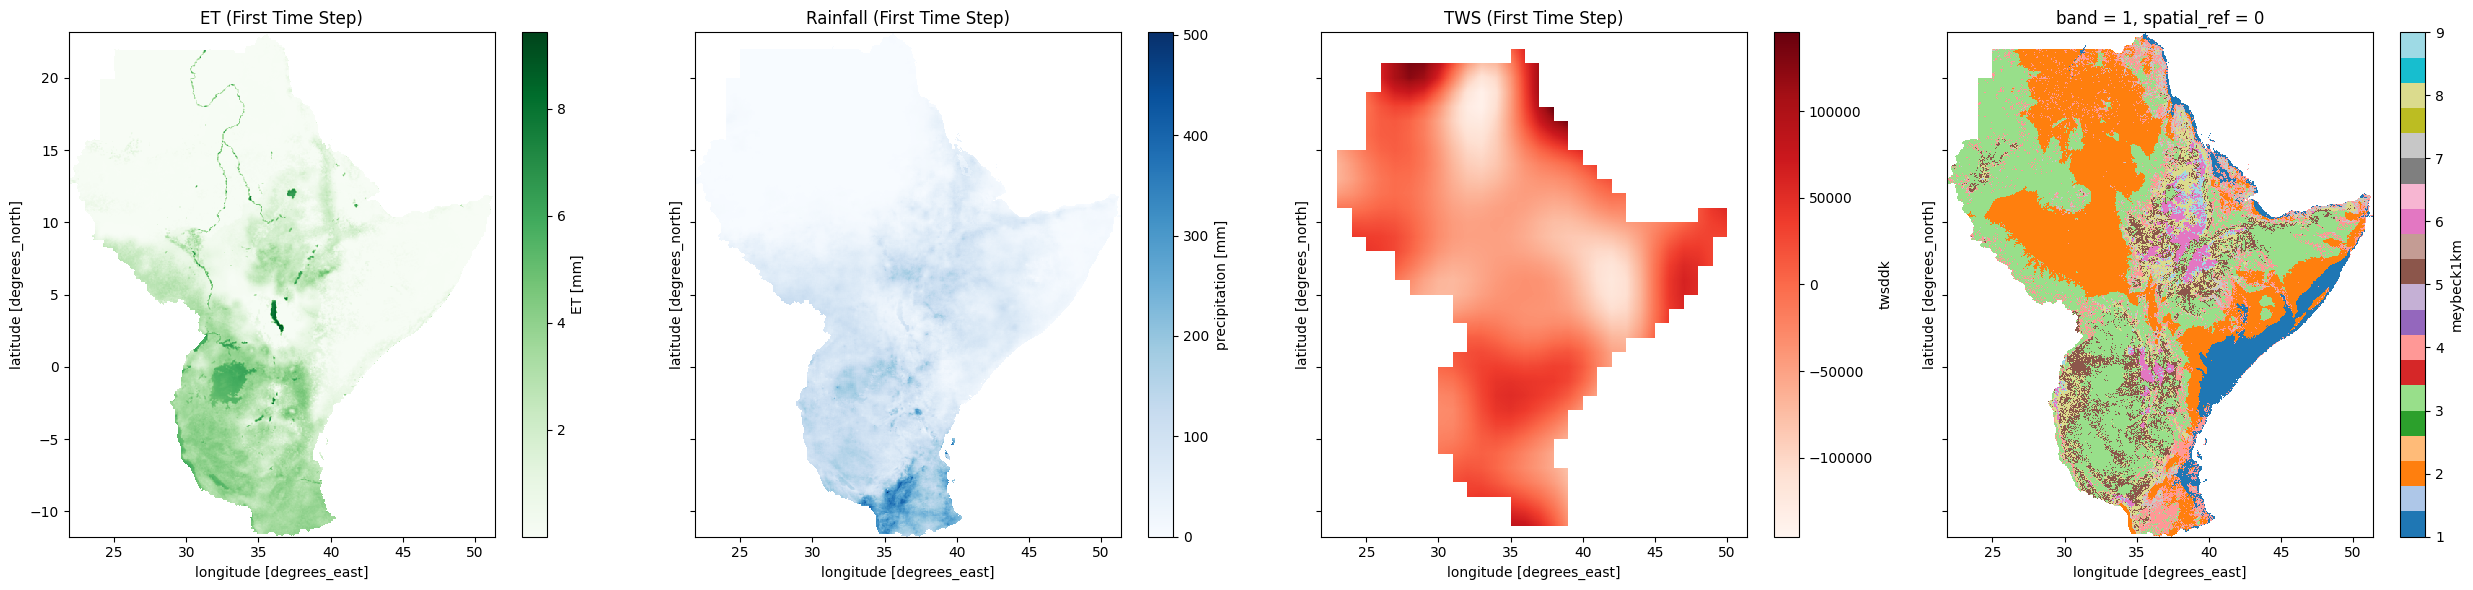

In [32]:
# Plot the regrided datasets

et2 = et_data_regrid.isel(time=0)
precip2 = precipitation_data_regrid.isel(time=0)
tws2 = tws_data_regrid.isel(time=0)


# Set up the figure and axes (1 row, 3 columns)
fig, axes = plt.subplots(1, 4, figsize=(25, 6), sharey=True)


# Plot ET
et2.plot(ax=axes[0], cmap="Greens", add_colorbar=True)
axes[0].set_title("ET (First Time Step)")

# Plot Rainfall
precip2.plot(ax=axes[1], cmap="Blues", add_colorbar=True)
axes[1].set_title("Rainfall (First Time Step)")

# Plot TWS
tws2.plot(ax=axes[2], cmap="Reds", add_colorbar=True)
axes[2].set_title("TWS (First Time Step)")

landform_data_regrid.plot(ax=axes[3], cmap="tab20", add_colorbar=True)

plt.tight_layout()
plt.show()

In [33]:
# Get unique landform classes (subregions)
landform_2d = landform_data_regrid.squeeze()
landform_classes = np.unique(landform_2d.values)
print("Landform classes:", landform_classes)

Landform classes: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. nan]


In [34]:
# Assuming landform_2d is at 5 km resolution
for class_value in landform_classes:
    if np.isnan(class_value):
        continue
    mask = landform_2d == class_value
    n_pixels = mask.sum().item()  # Number of True values (valid pixels)
    print(f"Class {class_value}: {n_pixels} pixels")

Class 1.0: 12910 pixels
Class 2.0: 59445 pixels
Class 3.0: 67984 pixels
Class 4.0: 20408 pixels
Class 5.0: 17019 pixels
Class 6.0: 5569 pixels
Class 7.0: 6771 pixels
Class 8.0: 13514 pixels
Class 9.0: 2475 pixels


#### Exponential moving average

In [185]:
# Span = timestep
def apply_ema(da, span=3):
    return da.rolling_exp(time=span, window_type="span").mean()


# ds_et_ema = apply_ema(et_resampled, span=6)
# ds_precip_ema = apply_ema(precip_resampled, span=6)

In [ ]:
# Variables at a location in GHA

lat = -5.34
lon = 32.34

et_poi = ds_et_ema.sel(y=lat, x=lon, method='nearest')
pre_poi = ds_precip_ema.sel(y=lat, x=lon, method='nearest')
tws_poi = tws_data.sel(lat=lat, lon=lon, method='nearest')

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# ET time series
axes[0].plot(et_poi.time, et_poi.values, color='green', linewidth=2)
axes[0].set_title('ET at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[0].set_xlabel('Time', fontsize=10)
axes[0].set_ylabel('ET Values (mm)', fontsize=10)
axes[0].grid(True)

# Precipitation time series
axes[1].plot(pre_poi.time, pre_poi.values, color='blue', linewidth=2)
axes[1].set_title('Precipitation at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[1].set_xlabel('Time', fontsize=10)
axes[1].set_ylabel('Precipitation Values (mm)', fontsize=10)
axes[1].grid(True)

# TWS time series
axes[2].plot(tws_poi.time, tws_poi.values, color='red', linewidth=2)
axes[2].set_title('TWS at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[2].set_xlabel('Time', fontsize=10)
axes[2].set_ylabel('TWS Values (cm)', fontsize=10)
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [35]:
# Get unique landform values (subregion IDs), excluding NaN or invalid values
# subregion_ids = xr.DataArray(combined_ds['landform'].values.flatten()).dropna(dim='dim_0').unique()

# Dictionary to store subregion datasets
subregion_datasets = {}

# Loop through each subregion
for subregion_id in subregion_ids:
    if np.isnan(subregion_id): 
        continue
    # Mask the combined dataset where landform matches the subregion ID
    subregion_mask = combined_ds['landform'] == subregion_id
    subregion_ds = combined_ds.where(subregion_mask, drop=True)
    subregion_datasets[subregion_id.item()] = subregion_ds

# Example: Access subregion 1
print(subregion_datasets[1])

<xarray.Dataset>
Dimensions:      (y: 671, x: 337, time: 219)
Coordinates:
  * time         (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:...
    lat          (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
    lon          (x) float64 30.33 30.38 30.48 30.53 ... 51.18 51.28 51.33 51.38
    band         int64 1
  * y            (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
  * x            (x) float64 30.33 30.38 30.48 30.53 ... 51.18 51.28 51.33 51.38
    spatial_ref  int64 0
Data variables:
    tws          (y, x, time) float64 nan nan nan nan nan ... nan nan nan nan
    precip       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    et           (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    landform     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan


In [58]:
# # Dictionary to store data per subregion
# subregion_data = {}

# for class_value in landform_classes:
#     if np.isnan(class_value): 
#         continue
#     # Create a mask for the current landform class
#     mask = landform_2d == class_value

#     # Apply mask to each dataset
#     tws_subregion = merged_data['TWS'].where(mask, drop=True)
#     et_subregion = merged_data['ET'].where(mask, drop=True)
#     precip_subregion = merged_data['precipitation'].where(mask, drop=True)

#     # Store in dictionary (you can flatten spatial dims if needed)
#     subregion_data[class_value] = {
#         "tws": tws_subregion,
#         "et": et_subregion,
#         "precip": precip_subregion
#     }

### Standardization Anomalies

In [43]:
'''To remove climatology, calculate the monthly climatology (long-term mean and
standard deviation for each month) and then compute standardized anomalies for 
each variable (tws, precip, et) per subregion.'''

# Function to calculate standardized anomalies
def calc_standardized_anomalies(data, var_name):
    # Group by month and calculate climatological mean and std
    monthly_clim = data[var_name].groupby('time.month').mean('time')
    monthly_std = data[var_name].groupby('time.month').std('time')
    
    # Compute anomalies: (value - mean) / std
    anomalies = data[var_name].groupby('time.month') - monthly_clim
    standardized_anomalies = anomalies.groupby('time.month') / monthly_std
    
    return standardized_anomalies

In [44]:
# Apply to each subregion
for subregion_id, ds in subregion_datasets.items():
    ds['tws_anom'] = calc_standardized_anomalies(ds, 'tws')
    ds['precip_anom'] = calc_standardized_anomalies(ds, 'precip')
    ds['et_anom'] = calc_standardized_anomalies(ds, 'et')
    
    # Update the dataset
    subregion_datasets[subregion_id] = ds

# Example: Check anomalies for subregion 1
print(subregion_datasets[1][['tws_anom', 'precip_anom', 'et_anom']])

<xarray.Dataset>
Dimensions:      (y: 671, x: 337, time: 219)
Coordinates:
  * time         (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:...
    lat          (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
    lon          (x) float64 30.33 30.38 30.48 30.53 ... 51.18 51.28 51.33 51.38
    band         int64 1
  * y            (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
  * x            (x) float64 30.33 30.38 30.48 30.53 ... 51.18 51.28 51.33 51.38
    spatial_ref  int64 0
    month        (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10
Data variables:
    tws_anom     (y, x, time) float64 nan nan nan nan nan ... nan nan nan nan
    precip_anom  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    et_anom      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan


In [108]:
subregion_datasets[9]['tws_anom'].stack(all_points=['time', 'y', 'x']).dropna(dim='all_points').size

499539

(array([1.2540e+03, 8.9500e+02, 1.1270e+03, 1.1680e+03, 1.0640e+03,
        9.0700e+02, 7.0200e+02, 9.7400e+02, 2.1820e+03, 3.4700e+03,
        5.4710e+03, 7.2810e+03, 1.0937e+04, 1.7798e+04, 2.3875e+04,
        3.2017e+04, 4.3184e+04, 5.1282e+04, 5.9522e+04, 6.6441e+04,
        7.9014e+04, 8.2683e+04, 8.9451e+04, 9.3028e+04, 7.9342e+04,
        8.3108e+04, 8.1616e+04, 8.4321e+04, 7.4660e+04, 6.1669e+04,
        5.9612e+04, 4.4823e+04, 3.3757e+04, 2.6304e+04, 2.1992e+04,
        2.1567e+04, 1.3726e+04, 9.1180e+03, 6.8570e+03, 5.9220e+03,
        5.2370e+03, 4.4280e+03, 3.7650e+03, 2.8840e+03, 2.9140e+03,
        3.1750e+03, 1.6880e+03, 1.8420e+03, 4.6000e+01, 4.1000e+01]),
 array([-3.77278941, -3.61964471, -3.4665    , -3.3133553 , -3.1602106 ,
        -3.00706589, -2.85392119, -2.70077648, -2.54763178, -2.39448707,
        -2.24134237, -2.08819766, -1.93505296, -1.78190825, -1.62876355,
        -1.47561884, -1.32247414, -1.16932943, -1.01618473, -0.86304002,
        -0.70989532, -0.55

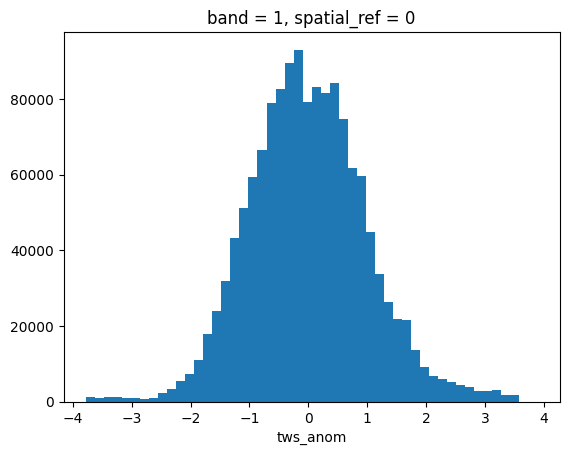

In [76]:
subregion_datasets[1]['tws_anom'].plot.hist(bins=50)

<AxesSubplot: ylabel='Count'>

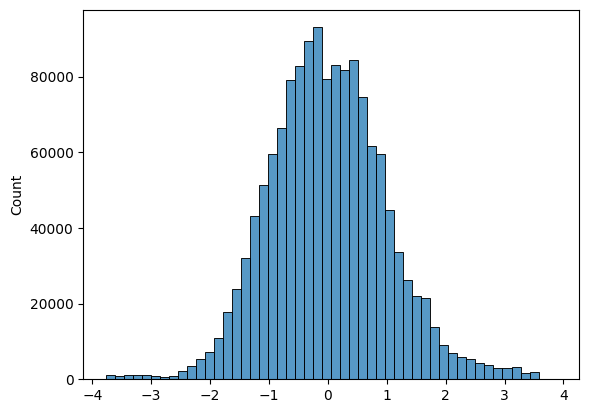

In [64]:
sns.histplot(subregion_datasets[1]['tws_anom'].values.flatten(), bins=50)

#### Export the anomalies

In [ ]:
# et_st_anomalies.to_netcdf(os.path.join(dataset, 'et_standardized_anomaly.nc'))
# pre_st_anomalies.to_netcdf(os.path.join(dataset, 'precip_standardized_anomaly.nc'))
# tws_st_anomalies.to_netcdf(os.path.join(dataset, 'tws_standardized_anomaly.nc'))

In [206]:
tq = np.sort(subregion_datasets[1]['tws_anom'].values[~np.isnan(subregion_datasets[1]['tws_anom'].values)])
print(tq)

[-3.77278941 -3.7666753  -3.76667132 ...  3.8830731   3.88381283
  3.88444582]


In [85]:
tq = np.sort(subregion_datasets[1]['tws_anom'].values[~np.isnan(subregion_datasets[1]['tws_anom'].values)])
print(tq)

[-3.77278941 -3.7666753  -3.76667132 ...  3.8830731   3.88381283
  3.88444582]


In [51]:
g = [np.nan, 4,6,7]


In [54]:
h = [4,5,6,2]

In [63]:
t = np.mean(h)
t

4.25

In [60]:
np.isnull(h)

AttributeError: module 'numpy' has no attribute 'isnull'

In [45]:
for i in g:
    h.append(i+2)
h

[nan, 6, 8, 9]

In [48]:
[i/np.mean(g) for i in h]

[nan, nan, nan, nan]

#### Fit Marginal Distributions Using `statsmodels` ECDF

In [115]:
# Function to compute ECDF using statsmodels
def compute_ecdf_statsmodels(data, var_name):
    # Stack and flatten the data, removing NaNs
    flat_data = data[var_name].stack(all_points=['time', 'y', 'x']).dropna(dim='all_points').values
    
    # Compute ECDF
    ecdf = ECDF(flat_data)
    cdf_values = ecdf(flat_data)  # Evaluate ECDF at the data points
    
    # Reconstruct as DataArray
    return xr.DataArray(
        cdf_values,
        coords={'all_points': data[var_name].stack(all_points=['time', 'y', 'x']).dropna(dim='all_points').coords['all_points']},
        dims=['all_points']
    ).unstack()


In [ ]:
# Apply to each subregion
for subregion_id, ds in subregion_datasets.items():
    ds['tws_cdf'] = compute_ecdf_statsmodels(ds, 'tws_anom')
    ds['precip_cdf'] = compute_ecdf_statsmodels(ds, 'precip_anom')
    ds['et_cdf'] = compute_ecdf_statsmodels(ds, 'et_anom')
    
    # Update the dataset
    subregion_datasets[subregion_id] = ds

# Example: Check CDFs for the first subregion
first_subregion_id = list(subregion_datasets.keys())[0]
print(subregion_datasets[first_subregion_id][['tws_cdf', 'precip_cdf', 'et_cdf']])

In [122]:
# Function to compute ECDF with a common mask
def compute_ecdf_statsmodels_consistent(ds):
    # Convert the selected variables to a single DataArray with 'variable' dimension
    data_vars = ds[['tws_anom', 'precip_anom', 'et_anom']].to_array(dim='variable')
    
    # Stack spatial and temporal dimensions
    stacked_data = data_vars.stack(all_points=['time', 'y', 'x'])
    
    # Create a common mask where all variables are non-NaN
    common_mask = stacked_data.notnull().all(dim='variable')
    valid_data = stacked_data.where(common_mask, drop=True)
    # print(valid_data)
    
    # Compute ECDF for each variable
    ecdf_dict = {}
    for var_name in ['tws_anom', 'precip_anom', 'et_anom']:
        flat_data = valid_data.sel(variable=var_name).values
        ecdf = ECDF(flat_data)
        cdf_values = ecdf(flat_data)
        ecdf_dict[var_name] = xr.DataArray(
            cdf_values,
            coords={'all_points': valid_data.sel(variable=var_name).coords['all_points']},
            dims=['all_points']
        ).unstack()
    
    return ecdf_dict['tws_anom'], ecdf_dict['precip_anom'], ecdf_dict['et_anom']


In [124]:
#  Apply to each subregion
for subregion_id, ds in subregion_datasets.items():
    tws_cdf, precip_cdf, et_cdf = compute_ecdf_statsmodels_consistent(ds)
    ds['tws_cdf'] = tws_cdf
    ds['precip_cdf'] = precip_cdf
    ds['et_cdf'] = et_cdf
    subregion_datasets[subregion_id] = ds


In [131]:
tws_len = subregion_datasets[1]['tws_cdf'].stack(all_points=['time', 'y', 'x']).dropna(dim='all_points').size
precip_len = subregion_datasets[1]['precip_cdf'].stack(all_points=['time', 'y', 'x']).dropna(dim='all_points').size
et_len = subregion_datasets[1]['et_cdf'].stack(all_points=['time', 'y', 'x']).dropna(dim='all_points').size
print(f"Lengths: tws_cdf={tws_len}, precip_cdf={precip_len}, et_cdf={et_len}")
print(ds[['tws_cdf', 'precip_cdf', 'et_cdf']])

Lengths: tws_cdf=1390176, precip_cdf=1390176, et_cdf=1390176
<xarray.Dataset>
Dimensions:      (time: 219, y: 360, x: 207)
Coordinates:
  * time         (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:...
  * y            (y) float64 17.62 17.57 17.37 17.32 ... -9.775 -9.875 -9.925
  * x            (x) float64 24.23 24.28 24.33 24.38 ... 42.63 42.68 42.73 47.28
    lat          (y) float64 17.62 17.57 17.37 17.32 ... -9.775 -9.875 -9.925
    lon          (x) float64 24.23 24.28 24.33 24.38 ... 42.63 42.68 42.73 47.28
    band         int64 1
    spatial_ref  int64 0
    month        (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10
Data variables:
    tws_cdf      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    precip_cdf   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    et_cdf       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan


In [208]:
len(subregion_datasets[1]['et_anom'].values.flatten())

49521813

In [166]:
f = subregion_datasets[1]['et_cdf'].values

In [157]:
from copulae.core import pseudo_obs

pseudo_obs(flatten)

array([0.5460973 , 0.45717023, 0.44608472, ..., 0.98954527, 0.99077544,
       0.98919175])

In [163]:
for i, j in subregion_datasets.items():
    print('id - {}'.format(i), j)

id - 1.0 <xarray.Dataset>
Dimensions:        (time: 219, y: 671, x: 337)
Coordinates:
  * time           (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T1...
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
  * x              (x) float64 30.33 30.38 30.48 30.53 ... 51.28 51.33 51.38
    lat            (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
    lon            (x) float64 30.33 30.38 30.48 30.53 ... 51.28 51.33 51.38
    band           int64 1
    spatial_ref    int64 0
    month          (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10
Data variables:
    tws            (y, x, time) float64 nan nan nan nan nan ... nan nan nan nan
    precip         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    et             (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    landform       (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    tws_anom       (y, x, time) float64 nan nan na

In [130]:
flatten = subregion_datasets[1]['precip_anom'].stack(all_points=['time', 'y', 'x']).dropna(dim='all_points').values
len(flatten)

2806096

#### Test workflow for the First Subregion - `The Plains (12,910 pixels)`

In [143]:
# Get the first subregion ID and dataset
first_subregion_id = list(subregion_datasets.keys())[0]
ds = subregion_datasets[first_subregion_id]
print(f"Testing subregion: {first_subregion_id}")

Testing subregion: 1.0


In [215]:

drought_index_standardized = xr.apply_ufunc(norm.ppf, ds.drought_index, keep_attrs=True).rename("Drought Index")

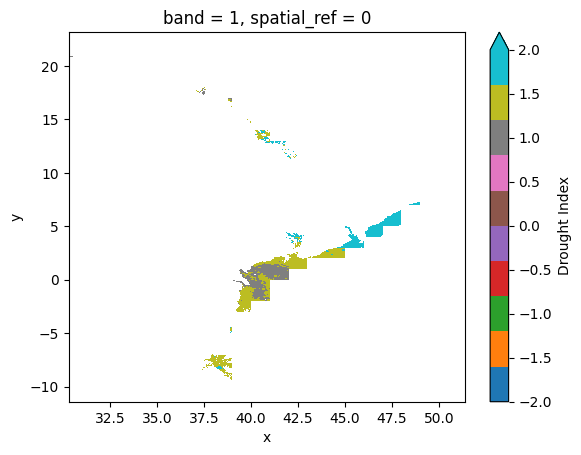

In [308]:
drought_index_standardized.sel(time=slice("2008-01-01", "2009-05-31")).mean(dim="time").plot(
    robust=True, cmap="tab10", vmin=-2, vmax=2
)

In [92]:
subregion_datasets

{1.0: <xarray.Dataset>
 Dimensions:      (y: 671, x: 337, time: 219)
 Coordinates:
   * time         (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:...
     lat          (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
     lon          (x) float64 30.33 30.38 30.48 30.53 ... 51.18 51.28 51.33 51.38
     band         int64 1
   * y            (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
   * x            (x) float64 30.33 30.38 30.48 30.53 ... 51.18 51.28 51.33 51.38
     spatial_ref  int64 0
     month        (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10
 Data variables:
     tws          (y, x, time) float64 nan nan nan nan nan ... nan nan nan nan
     precip       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
     et           (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
     landform     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
     tws_anom     (y, x, time) float64 nan nan

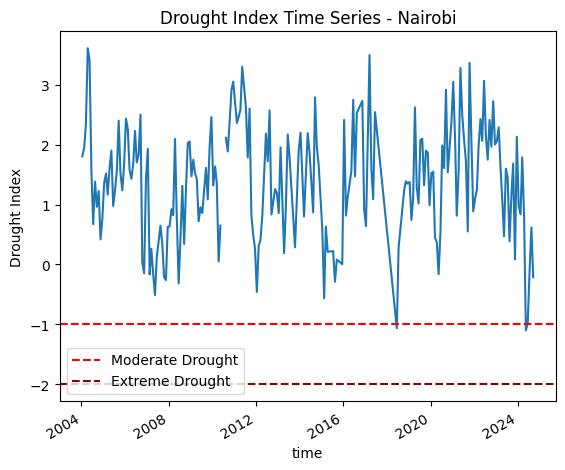

In [223]:
drought_index_standardized.sel(y=0, x=42, method="nearest").plot()
plt.title("Drought Index Time Series - Nairobi")
plt.axhline(y=-1, color='r', linestyle='--', label="Moderate Drought")
plt.axhline(y=-2, color='darkred', linestyle='--', label="Extreme Drought")
plt.legend()
plt.show()

#### Subregional 

In [306]:

# Function to test and select the best copula
def fit_best_copula(tws_cdf, precip_cdf, et_cdf):
    uniform_data = pd.DataFrame({
        'tws': tws_cdf.values,
        'precip': precip_cdf.values,
        'et': et_cdf.values
    }).dropna()
    
    copulas = {
        'Gaussian': GaussianCopula(dim=3),
        'Clayton': ClaytonCopula(dim=3),
        'Frank': FrankCopula(dim=3),
        'Gumbel': GumbelCopula(dim=3),
        'tCopula': StudentCopula(dim=3)
    }
    
    results = {}
    for name, copula in copulas.items():
        try:
            copula.fit(uniform_data)
            log_lik = copula.log_lik(uniform_data)
            if name in ['Clayton', 'Gumbel', 'Frank']:
                n_params = np.array(copula.params).size
            elif name == 'Gaussian':
                n_params = copula.params.size
            aic = -2 * log_lik + 2 * n_params
            bic = -2 * log_lik + np.log(uniform_data.shape[0]) * n_params
            results[name] = {
                "Log-Likelihood": log_lik,
                "AIC": aic,
                "BIC": bic,
                "Parameters": copula.params,
                "copula": copula
            }
            print(f"{name} Copula: Log-Likelihood={log_lik:.2f}, AIC={aic:.2f}, BIC={bic:.2f}")
        except Exception as e:
            print(f"Error fitting {name} copula: {e}")
            results[name] = {
                "Log-Likelihood": -np.inf,
                "AIC": np.inf,
                "BIC": np.inf,
                "Parameters": None,
                "copula": None
            }
    
    best_copula_name = min(results, key=lambda x: results[x]['AIC'])
    best_copula = results[best_copula_name]['copula']
    print(f"Best copula (by AIC): {best_copula_name} (AIC: {results[best_copula_name]['AIC']:.2f})")
    return best_copula, results


In [119]:
# Function to compute drought index
def compute_copula_index(ds):
    stacked_data = ds[['tws_cdf', 'precip_cdf', 'et_cdf']].stack(all_points=['time', 'y', 'x'])
    
    # Extract CDF values
    tws_cdf = stacked_data['tws_cdf']
    precip_cdf = stacked_data['precip_cdf']
    et_cdf = stacked_data['et_cdf']
    
    best_copula, copula_results = fit_best_copula(tws_cdf, precip_cdf, et_cdf)
    
    return best_copula, copula_results
    
#     data_for_cdf = pd.DataFrame({
#         'tws': tws_cdf.values,
#         'precip': precip_cdf.values,
#         'et': et_cdf.values
#     })
#     joint_cdf = best_copula.cdf(data_for_cdf)
#     drought_index = 1 - joint_cdf
    
#     return xr.DataArray(
#         drought_index,
#         coords={'all_points': stacked_data.coords['all_points']},
#         dims=['all_points']
#     ).unstack(), best_copula

# # Compute drought index for the first subregion
# drought_index, best_copula = compute_copula_index(ds)
# ds['drought_index'] = drought_index
# print(ds['drought_index'])

In [132]:
# Process all subregions and store results
best_copulas = {}
copula_metrics = {}
for subregion_id, ds in subregion_datasets.items():
    print(f"Processing subregion: {subregion_id}")
    # drought_index, best_copula, copula_results = compute_copula_index(ds)
    # ds['drought_index'] = drought_index
    best_copula, copula_results = compute_copula_index(ds)
    subregion_datasets[subregion_id] = ds
    best_copulas[subregion_id] = best_copula
    copula_metrics[subregion_id] = copula_results


Processing subregion: 1.0
                tws        precip            et
count  1.390176e+06  1.390176e+06  1.390176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    7.193329e-07  7.193329e-07  7.193329e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999993e-01  9.999993e-01  9.999993e-01
Gaussian Copula: Log-Likelihood=62230.99, AIC=-124455.98, BIC=-124419.55
                tws        precip            et
count  1.390176e+06  1.390176e+06  1.390176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    7.193329e-07  7.193329e-07  7.193329e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999993e-01  9.999993e-01  9.999993e-01
Clayton Copula: Log-Likelihood=12341.

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                tws        precip            et
count  1.390176e+06  1.390176e+06  1.390176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    7.193329e-07  7.193329e-07  7.193329e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999993e-01  9.999993e-01  9.999993e-01


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=23103.53, AIC=-46205.07, BIC=-46192.92
Best copula (by AIC): Gaussian (AIC: -124455.98)
Processing subregion: 2.0
                tws        precip            et
count  1.183291e+07  1.183291e+07  1.183291e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    8.451004e-08  8.451004e-08  8.451004e-08
25%    2.500000e-01  2.500000e-01  2.500000e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.500000e-01  7.500000e-01  7.500000e-01
max    9.999999e-01  9.999999e-01  9.999999e-01
Gaussian Copula: Log-Likelihood=15855.36, AIC=-31704.73, BIC=-31661.87
                tws        precip            et
count  1.183291e+07  1.183291e+07  1.183291e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    8.451004e-08  8.451004e-08  8.451004e-08
25%    2.500000e-01  2.500000e-01  2.500000e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.500000e-

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                tws        precip            et
count  1.183291e+07  1.183291e+07  1.183291e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    8.451004e-08  8.451004e-08  8.451004e-08
25%    2.500000e-01  2.500000e-01  2.500000e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.500000e-01  7.500000e-01  7.500000e-01
max    9.999999e-01  9.999999e-01  9.999999e-01


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=10683.98, AIC=-21365.95, BIC=-21351.67
Best copula (by AIC): Clayton (AIC: -70997421.63)
Processing subregion: 3.0
                tws        precip            et
count  1.278634e+07  1.278634e+07  1.278634e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    7.820848e-08  7.820848e-08  7.820848e-08
25%    2.500000e-01  2.500000e-01  2.500000e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.500000e-01  7.500000e-01  7.500000e-01
max    9.999999e-01  9.999999e-01  9.999999e-01
Gaussian Copula: Log-Likelihood=13447.63, AIC=-26889.25, BIC=-26846.16
                tws        precip            et
count  1.278634e+07  1.278634e+07  1.278634e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    7.820848e-08  7.820848e-08  7.820848e-08
25%    2.500000e-01  2.500000e-01  2.500000e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.500000e

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=14188.07, AIC=-28374.13, BIC=-28359.77
Best copula (by AIC): Gumbel (AIC: -28374.13)
Processing subregion: 4.0
                tws        precip            et
count  3.183624e+06  3.183624e+06  3.183624e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.141073e-07  3.141073e-07  3.141073e-07
25%    2.500002e-01  2.500002e-01  2.500002e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499998e-01  7.499998e-01  7.499998e-01
max    9.999997e-01  9.999997e-01  9.999997e-01
Gaussian Copula: Log-Likelihood=13175.95, AIC=-26345.91, BIC=-26306.99
                tws        precip            et
count  3.183624e+06  3.183624e+06  3.183624e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.141073e-07  3.141073e-07  3.141073e-07
25%    2.500002e-01  2.500002e-01  2.500002e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499998e-01 

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=10086.22, AIC=-20170.44, BIC=-20157.46
Best copula (by AIC): Gaussian (AIC: -26345.91)
Processing subregion: 5.0
                tws        precip            et
count  3.338712e+06  3.338712e+06  3.338712e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    2.995166e-07  2.995166e-07  2.995166e-07
25%    2.500001e-01  2.500001e-01  2.500001e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499999e-01  7.499999e-01  7.499999e-01
max    9.999997e-01  9.999997e-01  9.999997e-01
Gaussian Copula: Log-Likelihood=4805.97, AIC=-9605.95, BIC=-9566.89
                tws        precip            et
count  3.338712e+06  3.338712e+06  3.338712e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    2.995166e-07  2.995166e-07  2.995166e-07
25%    2.500001e-01  2.500001e-01  2.500001e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499999e-01  

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=9508.60, AIC=-19015.20, BIC=-19002.18
Best copula (by AIC): Gumbel (AIC: -19015.20)
Processing subregion: 6.0
                tws        precip            et
count  1.136160e+06  1.136160e+06  1.136160e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    8.801569e-07  8.801569e-07  8.801569e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999991e-01  9.999991e-01  9.999991e-01
Gaussian Copula: Log-Likelihood=2074.84, AIC=-4143.68, BIC=-4107.85
Error fitting Clayton copula: theta must be positive when dim > 2
Error fitting Frank copula: theta must be positive when dim > 2


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                tws        precip            et
count  1.136160e+06  1.136160e+06  1.136160e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    8.801569e-07  8.801569e-07  8.801569e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999991e-01  9.999991e-01  9.999991e-01


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=1457.27, AIC=-2912.53, BIC=-2900.59
Best copula (by AIC): Gaussian (AIC: -4143.68)
Processing subregion: 7.0
                tws        precip            et
count  1.093176e+06  1.093176e+06  1.093176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    9.147649e-07  9.147649e-07  9.147649e-07
25%    2.500005e-01  2.500005e-01  2.500005e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499995e-01  7.499995e-01  7.499995e-01
max    9.999991e-01  9.999991e-01  9.999991e-01
Gaussian Copula: Log-Likelihood=604.36, AIC=-1202.72, BIC=-1167.00
                tws        precip            et
count  1.093176e+06  1.093176e+06  1.093176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    9.147649e-07  9.147649e-07  9.147649e-07
25%    2.500005e-01  2.500005e-01  2.500005e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499995e-01  7.499

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=1151.15, AIC=-2300.29, BIC=-2288.39
Best copula (by AIC): Gumbel (AIC: -2300.29)
Processing subregion: 8.0
                tws        precip            et
count  2.579904e+06  2.579904e+06  2.579904e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.876112e-07  3.876112e-07  3.876112e-07
25%    2.500002e-01  2.500002e-01  2.500002e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499998e-01  7.499998e-01  7.499998e-01
max    9.999996e-01  9.999996e-01  9.999996e-01
Gaussian Copula: Log-Likelihood=457.11, AIC=-908.22, BIC=-869.93
                tws        precip            et
count  2.579904e+06  2.579904e+06  2.579904e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.876112e-07  3.876112e-07  3.876112e-07
25%    2.500002e-01  2.500002e-01  2.500002e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499998e-01  7.499998e

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                tws        precip            et
count  2.579904e+06  2.579904e+06  2.579904e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.876112e-07  3.876112e-07  3.876112e-07
25%    2.500002e-01  2.500002e-01  2.500002e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499998e-01  7.499998e-01  7.499998e-01
max    9.999996e-01  9.999996e-01  9.999996e-01


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=4780.79, AIC=-9559.57, BIC=-9546.81
Best copula (by AIC): Clayton (AIC: -15479378.20)
Processing subregion: 9.0
                 tws         precip             et
count  492696.000000  492696.000000  492696.000000
mean        0.500000       0.500000       0.500000
std         0.288675       0.288675       0.288675
min         0.000002       0.000002       0.000002
25%         0.250001       0.250001       0.250001
50%         0.500000       0.500000       0.500000
75%         0.749999       0.749999       0.749999
max         0.999998       0.999998       0.999998
Gaussian Copula: Log-Likelihood=1135.29, AIC=-2264.59, BIC=-2231.26
Error fitting Clayton copula: theta must be positive when dim > 2
Error fitting Frank copula: theta must be positive when dim > 2


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                 tws         precip             et
count  492696.000000  492696.000000  492696.000000
mean        0.500000       0.500000       0.500000
std         0.288675       0.288675       0.288675
min         0.000002       0.000002       0.000002
25%         0.250001       0.250001       0.250001
50%         0.500000       0.500000       0.500000
75%         0.749999       0.749999       0.749999
max         0.999998       0.999998       0.999998


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=960.34, AIC=-1918.68, BIC=-1907.57
Best copula (by AIC): Gaussian (AIC: -2264.59)


In [142]:
for i in best_copulas.items():
    print ('Subregion - ',i[0],i[1]._name)

Subregion -  1.0 Gaussian
Subregion -  2.0 Clayton
Subregion -  3.0 Gumbel
Subregion -  4.0 Gaussian
Subregion -  5.0 Gumbel
Subregion -  6.0 Gaussian
Subregion -  7.0 Gumbel
Subregion -  8.0 Clayton
Subregion -  9.0 Gaussian


In [307]:
# Process all subregions and store results including tCopula
best_copulas = {}
copula_metrics = {}
for subregion_id, ds in subregion_datasets.items():
    print(f"Processing subregion: {subregion_id}")
    # drought_index, best_copula, copula_results = compute_copula_index(ds)
    # ds['drought_index'] = drought_index
    best_copula, copula_results = compute_copula_index(ds)
    subregion_datasets[subregion_id] = ds
    best_copulas[subregion_id] = best_copula
    copula_metrics[subregion_id] = copula_results

Processing subregion: 1.0
                tws        precip            et
count  1.390176e+06  1.390176e+06  1.390176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    7.193329e-07  7.193329e-07  7.193329e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999993e-01  9.999993e-01  9.999993e-01
Gaussian Copula: Log-Likelihood=62230.99, AIC=-124455.98, BIC=-124419.55
                tws        precip            et
count  1.390176e+06  1.390176e+06  1.390176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    7.193329e-07  7.193329e-07  7.193329e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999993e-01  9.999993e-01  9.999993e-01
Clayton Copula: Log-Likelihood=12341.

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                tws        precip            et
count  1.390176e+06  1.390176e+06  1.390176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    7.193329e-07  7.193329e-07  7.193329e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999993e-01  9.999993e-01  9.999993e-01


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=23103.53, AIC=-46205.07, BIC=-46192.92
Error fitting tCopula copula: Unable to allocate 14.1 TiB for an array with shape (1390176, 1390176) and data type float64
Best copula (by AIC): Gaussian (AIC: -124455.98)
Processing subregion: 2.0
                tws        precip            et
count  1.183291e+07  1.183291e+07  1.183291e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    8.451004e-08  8.451004e-08  8.451004e-08
25%    2.500000e-01  2.500000e-01  2.500000e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.500000e-01  7.500000e-01  7.500000e-01
max    9.999999e-01  9.999999e-01  9.999999e-01
Gaussian Copula: Log-Likelihood=15855.36, AIC=-31704.73, BIC=-31661.87
                tws        precip            et
count  1.183291e+07  1.183291e+07  1.183291e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    8.451004e-08  8.451004e-08  8.4

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                tws        precip            et
count  1.183291e+07  1.183291e+07  1.183291e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    8.451004e-08  8.451004e-08  8.451004e-08
25%    2.500000e-01  2.500000e-01  2.500000e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.500000e-01  7.500000e-01  7.500000e-01
max    9.999999e-01  9.999999e-01  9.999999e-01


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=10683.98, AIC=-21365.95, BIC=-21351.67
Error fitting tCopula copula: Unable to allocate 1019. TiB for an array with shape (11832912, 11832912) and data type float64
Best copula (by AIC): Clayton (AIC: -70997421.63)
Processing subregion: 3.0
                tws        precip            et
count  1.278634e+07  1.278634e+07  1.278634e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    7.820848e-08  7.820848e-08  7.820848e-08
25%    2.500000e-01  2.500000e-01  2.500000e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.500000e-01  7.500000e-01  7.500000e-01
max    9.999999e-01  9.999999e-01  9.999999e-01
Gaussian Copula: Log-Likelihood=13447.63, AIC=-26889.25, BIC=-26846.16
                tws        precip            et
count  1.278634e+07  1.278634e+07  1.278634e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    7.820848e-08  7.820848e-08 

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=14188.07, AIC=-28374.13, BIC=-28359.77
Error fitting tCopula copula: Unable to allocate 1.16 PiB for an array with shape (12786336, 12786336) and data type float64
Best copula (by AIC): Gumbel (AIC: -28374.13)
Processing subregion: 4.0
                tws        precip            et
count  3.183624e+06  3.183624e+06  3.183624e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.141073e-07  3.141073e-07  3.141073e-07
25%    2.500002e-01  2.500002e-01  2.500002e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499998e-01  7.499998e-01  7.499998e-01
max    9.999997e-01  9.999997e-01  9.999997e-01
Gaussian Copula: Log-Likelihood=13175.95, AIC=-26345.91, BIC=-26306.99
                tws        precip            et
count  3.183624e+06  3.183624e+06  3.183624e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.141073e-07  3.141073e-07  3.14

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=10086.22, AIC=-20170.44, BIC=-20157.46
Error fitting tCopula copula: Unable to allocate 73.7 TiB for an array with shape (3183624, 3183624) and data type float64
Best copula (by AIC): Gaussian (AIC: -26345.91)
Processing subregion: 5.0
                tws        precip            et
count  3.338712e+06  3.338712e+06  3.338712e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    2.995166e-07  2.995166e-07  2.995166e-07
25%    2.500001e-01  2.500001e-01  2.500001e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499999e-01  7.499999e-01  7.499999e-01
max    9.999997e-01  9.999997e-01  9.999997e-01
Gaussian Copula: Log-Likelihood=4805.97, AIC=-9605.95, BIC=-9566.89
                tws        precip            et
count  3.338712e+06  3.338712e+06  3.338712e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    2.995166e-07  2.995166e-07  2.99516

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=9508.60, AIC=-19015.20, BIC=-19002.18
Error fitting tCopula copula: Unable to allocate 81.1 TiB for an array with shape (3338712, 3338712) and data type float64
Best copula (by AIC): Gumbel (AIC: -19015.20)
Processing subregion: 6.0
                tws        precip            et
count  1.136160e+06  1.136160e+06  1.136160e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    8.801569e-07  8.801569e-07  8.801569e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999991e-01  9.999991e-01  9.999991e-01
Gaussian Copula: Log-Likelihood=2074.84, AIC=-4143.68, BIC=-4107.85
Error fitting Clayton copula: theta must be positive when dim > 2
Error fitting Frank copula: theta must be positive when dim > 2


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                tws        precip            et
count  1.136160e+06  1.136160e+06  1.136160e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    8.801569e-07  8.801569e-07  8.801569e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999991e-01  9.999991e-01  9.999991e-01


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=1457.27, AIC=-2912.53, BIC=-2900.59
Error fitting tCopula copula: Unable to allocate 9.39 TiB for an array with shape (1136160, 1136160) and data type float64
Best copula (by AIC): Gaussian (AIC: -4143.68)
Processing subregion: 7.0
                tws        precip            et
count  1.093176e+06  1.093176e+06  1.093176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    9.147649e-07  9.147649e-07  9.147649e-07
25%    2.500005e-01  2.500005e-01  2.500005e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499995e-01  7.499995e-01  7.499995e-01
max    9.999991e-01  9.999991e-01  9.999991e-01
Gaussian Copula: Log-Likelihood=604.36, AIC=-1202.72, BIC=-1167.00
                tws        precip            et
count  1.093176e+06  1.093176e+06  1.093176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    9.147649e-07  9.147649e-07  9.147649e-07

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=1151.15, AIC=-2300.29, BIC=-2288.39
Error fitting tCopula copula: Unable to allocate 8.70 TiB for an array with shape (1093176, 1093176) and data type float64
Best copula (by AIC): Gumbel (AIC: -2300.29)
Processing subregion: 8.0
                tws        precip            et
count  2.579904e+06  2.579904e+06  2.579904e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.876112e-07  3.876112e-07  3.876112e-07
25%    2.500002e-01  2.500002e-01  2.500002e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499998e-01  7.499998e-01  7.499998e-01
max    9.999996e-01  9.999996e-01  9.999996e-01
Gaussian Copula: Log-Likelihood=457.11, AIC=-908.22, BIC=-869.93
                tws        precip            et
count  2.579904e+06  2.579904e+06  2.579904e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.876112e-07  3.876112e-07  3.876112e-07
25%

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                tws        precip            et
count  2.579904e+06  2.579904e+06  2.579904e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.876112e-07  3.876112e-07  3.876112e-07
25%    2.500002e-01  2.500002e-01  2.500002e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499998e-01  7.499998e-01  7.499998e-01
max    9.999996e-01  9.999996e-01  9.999996e-01


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=4780.79, AIC=-9559.57, BIC=-9546.81
Error fitting tCopula copula: Unable to allocate 48.4 TiB for an array with shape (2579904, 2579904) and data type float64
Best copula (by AIC): Clayton (AIC: -15479378.20)
Processing subregion: 9.0
                 tws         precip             et
count  492696.000000  492696.000000  492696.000000
mean        0.500000       0.500000       0.500000
std         0.288675       0.288675       0.288675
min         0.000002       0.000002       0.000002
25%         0.250001       0.250001       0.250001
50%         0.500000       0.500000       0.500000
75%         0.749999       0.749999       0.749999
max         0.999998       0.999998       0.999998
Gaussian Copula: Log-Likelihood=1135.29, AIC=-2264.59, BIC=-2231.26
Error fitting Clayton copula: theta must be positive when dim > 2
Error fitting Frank copula: theta must be positive when dim > 2


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                 tws         precip             et
count  492696.000000  492696.000000  492696.000000
mean        0.500000       0.500000       0.500000
std         0.288675       0.288675       0.288675
min         0.000002       0.000002       0.000002
25%         0.250001       0.250001       0.250001
50%         0.500000       0.500000       0.500000
75%         0.749999       0.749999       0.749999
max         0.999998       0.999998       0.999998


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=960.34, AIC=-1918.68, BIC=-1907.57
Error fitting tCopula copula: Unable to allocate 1.77 TiB for an array with shape (492696, 492696) and data type float64
Best copula (by AIC): Gaussian (AIC: -2264.59)


In [308]:
for i in best_copulas.items():
    print ('Subregion - ',i[0],i[1]._name)

Subregion -  1.0 Gaussian
Subregion -  2.0 Clayton
Subregion -  3.0 Gumbel
Subregion -  4.0 Gaussian
Subregion -  5.0 Gumbel
Subregion -  6.0 Gaussian
Subregion -  7.0 Gumbel
Subregion -  8.0 Clayton
Subregion -  9.0 Gaussian


In [423]:
# Save the final dataset
final_ds = combined_ds.copy()
final_ds.to_netcdf(os.path.join(dataset, 'drought_index_gha_base.nc'))  # Base dataset without drought index
print("Base dataset saved as 'drought_index_gha_base.nc'")

Base dataset saved as 'drought_index_gha_base.nc'


In [155]:
subregion_datasets

{1.0: <xarray.Dataset>
 Dimensions:      (time: 219, y: 671, x: 337)
 Coordinates:
   * time         (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:...
   * y            (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
   * x            (x) float64 30.33 30.38 30.48 30.53 ... 51.18 51.28 51.33 51.38
     lat          (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
     lon          (x) float64 30.33 30.38 30.48 30.53 ... 51.18 51.28 51.33 51.38
     band         int64 1
     spatial_ref  int64 0
     month        (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10
 Data variables:
     tws          (y, x, time) float64 nan nan nan nan nan ... nan nan nan nan
     precip       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
     et           (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
     landform     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
     tws_anom     (y, x, time) float64 nan nan

In [157]:
# Lookup and apply functions
def lookup_best_copula(subregion_id):
    if subregion_id not in best_copulas:
        raise ValueError(f"Subregion {subregion_id} not found in processed data.")
    
    best_copula = best_copulas[subregion_id]
    metrics = copula_metrics[subregion_id]
    best_copula_name = min(metrics, key=lambda x: metrics[x]['AIC'])
    
    print(f"Subregion {subregion_id}:")
    print(f"Best Copula: {best_copula_name}")
    print(f"Log-Likelihood: {metrics[best_copula_name]['Log-Likelihood']:.2f}")
    print(f"AIC: {metrics[best_copula_name]['AIC']:.2f}")
    print(f"BIC: {metrics[best_copula_name]['BIC']:.2f}")
    print(f"Parameters: {metrics[best_copula_name]['Parameters']}")
    return best_copula

In [158]:
for id in best_copulas:
    lookup_best_copula(id)

Subregion 1.0:
Best Copula: Gaussian
Log-Likelihood: 62230.99
AIC: -124455.98
BIC: -124419.55
Parameters: [0.06915878 0.28476277 0.00718232]
Subregion 2.0:
Best Copula: Clayton
Log-Likelihood: 35498711.81
AIC: -70997421.63
BIC: -70997407.34
Parameters: 9.887588163557933e-20
Subregion 3.0:
Best Copula: Gumbel
Log-Likelihood: 14188.07
AIC: -28374.13
BIC: -28359.77
Parameters: 1.0112463444550825
Subregion 4.0:
Best Copula: Gaussian
Log-Likelihood: 13175.95
AIC: -26345.91
BIC: -26306.99
Parameters: [0.01188714 0.08624426 0.02681232]
Subregion 5.0:
Best Copula: Gumbel
Log-Likelihood: 9508.60
AIC: -19015.20
BIC: -19002.18
Parameters: 1.0170053317009793
Subregion 6.0:
Best Copula: Gaussian
Log-Likelihood: 2074.84
AIC: -4143.68
BIC: -4107.85
Parameters: [-0.02571496 -0.02844971  0.04737666]
Subregion 7.0:
Best Copula: Gumbel
Log-Likelihood: 1151.15
AIC: -2300.29
BIC: -2288.39
Parameters: 1.0100709456165555
Subregion 8.0:
Best Copula: Clayton
Log-Likelihood: 7739690.10
AIC: -15479378.20
BIC: -1

In [159]:

def apply_best_copula(subregion_id):
    if subregion_id not in subregion_datasets:
        raise ValueError(f"Subregion {subregion_id} not found in processed data.")
    
    ds = subregion_datasets[subregion_id]
    best_copula = best_copulas[subregion_id]
    
    stacked_data = ds[['tws_cdf', 'precip_cdf', 'et_cdf']].stack(all_points=['time', 'y', 'x'])
    tws_cdf = stacked_data['tws_cdf']
    precip_cdf = stacked_data['precip_cdf']
    et_cdf = stacked_data['et_cdf']
    
    common_mask = (tws_cdf.notnull() & precip_cdf.notnull() & et_cdf.notnull()).values
    
    data_for_cdf = pd.DataFrame({
        'tws': tws_cdf.values,
        'precip': precip_cdf.values,
        'et': et_cdf.values
    })[common_mask]
    joint_cdf = best_copula.cdf(data_for_cdf)
    joint_cdf = np.clip(joint_cdf, 0.001, 0.999)
    
    drought_index = norm.ppf(joint_cdf)
    
    full_drought_index = xr.DataArray(
        np.full(stacked_data['tws_cdf'].shape, np.nan),
        coords={'all_points': stacked_data.coords['all_points']},
        dims=['all_points']
    )
    # valid_indices = stacked_data['tws_cdf'].notnull().values
    full_drought_index.values[common_mask] = drought_index
    
    print(f"Drought index recomputed for subregion {subregion_id} using {best_copula.__class__.__name__}")
    return full_drought_index.unstack()


In [299]:
# Updated apply_best_copula
def apply_best_copula(subregion_id):
    if subregion_id not in subregion_datasets:
        raise ValueError(f"Subregion {subregion_id} not found in processed data.")
    
    ds = subregion_datasets[subregion_id]
    best_copula = best_copulas[subregion_id]
    
    # Get the subregion mask from the full dataset and ensure it’s 2D (y, x)
    subregion_mask_2d = (combined_ds['landform'] == subregion_id)
    
    # Apply the mask to limit the subregion dataset’s spatial extent
    ds_masked = ds.where(subregion_mask_2d)
    
    # Stack with consistent dimension order (assuming time, y, x)
    stacked_data = ds_masked[['tws_cdf', 'precip_cdf', 'et_cdf']].stack(all_points=['time', 'y', 'x'])
    tws_cdf = stacked_data['tws_cdf']
    precip_cdf = stacked_data['precip_cdf']
    et_cdf = stacked_data['et_cdf']
    
    # Common mask for valid data within the subregion
    common_mask = (tws_cdf.notnull() & precip_cdf.notnull() & et_cdf.notnull()).values
    
    data_for_cdf = pd.DataFrame({
        'tws': tws_cdf.values,
        'precip': precip_cdf.values,
        'et': et_cdf.values
    })[common_mask]
    
    joint_cdf = best_copula.cdf(data_for_cdf)
    joint_cdf = np.clip(joint_cdf, 0.001, 0.999)
    drought_index = norm.ppf(joint_cdf)
    
    # Create the subregion drought index
    full_drought_index = xr.DataArray(
        np.full(stacked_data['tws_cdf'].shape, np.nan),
        coords={'all_points': stacked_data.coords['all_points']},
        dims=['all_points']
    )
    full_drought_index.values[common_mask] = drought_index
    
    drought_index_da = full_drought_index.unstack()
    print(f"Drought index computed for subregion {subregion_id} using {best_copula.__class__.__name__}")
    return drought_index_da

In [177]:
# Combine drought indices into one for the full study area
def compute_full_drought_index():
    full_drought_index = xr.full_like(combined_ds['et'], np.nan)
    
    for subregion_id in subregion_datasets.keys():
        print(f"Applying best copula to subregion {subregion_id}")
        drought_index_subregion = apply_best_copula(subregion_id)
        subregion_mask = combined_ds['landform'] == subregion_id
        full_drought_index = xr.where(subregion_mask, drought_index_subregion, full_drought_index)
    
    return full_drought_index

In [225]:
def compute_full_drought_index():
    full_drought_index = xr.full_like(combined_ds['tws'], np.nan)
    full_drought_array = full_drought_index.values  # Shape: (time, y, x)
    
    for subregion_id in subregion_datasets.keys():
        print(f"Applying best copula to subregion {subregion_id}")
        drought_index_subregion = apply_best_copula(subregion_id)
        
        # Get the 2D spatial mask from the full dataset
        subregion_mask_2d = (combined_ds['landform'] == subregion_id).values
        
        # Broadcast to 3D
        time_size = full_drought_array.shape[0]
        subregion_mask_3d = np.broadcast_to(subregion_mask_2d[np.newaxis, :, :], (time_size,) + subregion_mask_2d.shape)
        
        # Verify shapes
        print(f"Subregion {subregion_id}:")
        print(f"  Full array shape: {full_drought_array.shape}")
        print(f"  Mask 3D shape: {subregion_mask_3d.shape}")
        print(f"  Drought index shape: {drought_index_subregion.shape}")
        print(f"  Number of True in mask: {subregion_mask_3d.sum()}")
        print(f"  Number of elements in drought index: {drought_index_subregion.size}")
        
        # Assign values, ensuring the number of elements matches
        if subregion_mask_3d.sum() == drought_index_subregion.size:
            full_drought_array[subregion_mask_3d] = drought_index_subregion.values.flatten()
        else:
            # If sizes don’t match, select only valid points from the subregion
            valid_mask = ~np.isnan(drought_index_subregion.values)
            if valid_mask.sum() == subregion_mask_3d.sum():
                full_drought_array[subregion_mask_3d] = drought_index_subregion.values[valid_mask]
            else:
                raise ValueError(f"Size mismatch for subregion {subregion_id}: mask has {subregion_mask_3d.sum()} True values, but drought index has {drought_index_subregion.size} elements, with {valid_mask.sum()} non-NaN")

    full_drought_index.values = full_drought_array
    return full_drought_index

In [301]:
# Updated compute_full_drought_index
def compute_full_drought_index():
    # Ensure full_drought_index matches combined_ds['tws'] shape (time, y, x)
    full_drought_index = xr.full_like(combined_ds['et'], np.nan)
    full_drought_array = full_drought_index.values  # Expected shape: (219, 698, 591)
    
    for subregion_id in subregion_datasets.keys():
        print(f"Applying best copula to subregion {subregion_id}")
        drought_index_subregion = apply_best_copula(subregion_id)
        
        # 2D mask from the full dataset
        subregion_mask_2d = (combined_ds['landform'] == subregion_id).values
        
        # Broadcast to 3D, ensuring time is the first dimension
        time_size = combined_ds['tws'].shape[0]  # e.g., 219
        subregion_mask_3d = np.broadcast_to(subregion_mask_2d[np.newaxis, :, :], (time_size,) + subregion_mask_2d.shape)
        
        # Debug shapes
        print(f"Subregion {subregion_id}:")
        print(f"  Full array shape: {full_drought_array.shape}")
        print(f"  Mask 3D shape: {subregion_mask_3d.shape}")
        print(f"  Drought index shape: {drought_index_subregion.shape}")
        print(f"  Number of True in mask: {subregion_mask_3d.sum()}")
        print(f"  Number of elements in drought index: {drought_index_subregion.size}")
        print(f"  Non-NaN in drought index: {np.isfinite(drought_index_subregion.values).sum()}")
        
        # Assign only non-NaN values from the subregion
        valid_mask = np.isfinite(drought_index_subregion.values)
        if subregion_mask_3d.sum() == valid_mask.sum():
            full_drought_array[subregion_mask_3d] = drought_index_subregion.values[valid_mask]
        else:
            raise ValueError(f"Size mismatch for subregion {subregion_id}: mask has {subregion_mask_3d.sum()} True values, "
                            f"but drought index has {valid_mask.sum()} non-NaN values")

    full_drought_index.values = full_drought_array
    return full_drought_index

In [302]:
# Compute and save the full drought index
full_drought_index = compute_full_drought_index()
final_ds = combined_ds.copy()
final_ds['drought_index'] = full_drought_index

Applying best copula to subregion 1.0
Drought index computed for subregion 1.0 using GaussianCopula
Subregion 1.0:
  Full array shape: (219, 698, 591)
  Mask 3D shape: (698, 698, 591)
  Drought index shape: (219, 671, 337)
  Number of True in mask: 9011180
  Number of elements in drought index: 49521813
  Non-NaN in drought index: 1390176


ValueError: Size mismatch for subregion 1.0: mask has 9011180 True values, but drought index has 1390176 non-NaN values

In [226]:
# Compute and save the full drought index
full_drought_index = compute_full_drought_index()
final_ds = combined_ds.copy()
final_ds['drought_index'] = full_drought_index

Applying best copula to subregion 1.0
Drought index recomputed for subregion 1.0 using GaussianCopula
Subregion 1.0:
  Full array shape: (698, 591, 219)
  Mask 3D shape: (698, 698, 591)
  Drought index shape: (219, 671, 337)
  Number of True in mask: 9011180
  Number of elements in drought index: 49521813


ValueError: Size mismatch for subregion 1.0: mask has 9011180 True values, but drought index has 49521813 elements, with 1390176 non-NaN

In [ ]:
final_ds.to_netcdf('drought_index_gha_full.nc')
print("Full drought index dataset saved as 'drought_index_gha_full.nc'")

In [ ]:
# Visualize
plt.figure(figsize=(12, 8))
full_drought_index.isel(time=0).plot(cmap='RdBu_r', vmin=-3, vmax=3)
plt.title("Full Study Area Drought Index (First Time Step)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Testing Individual Subregions

In [451]:
# Example usage
first_subregion_id = list(subregion_datasets.keys())[0]
best_copula = lookup_best_copula(first_subregion_id)
new_drought_index = apply_best_copula(first_subregion_id)

Subregion 1.0:
Best Copula: Gaussian
Log-Likelihood: 62230.99
AIC: -124455.98
BIC: -124419.55
Parameters: [0.06915876 0.28476279 0.00718228]
Drought index recomputed for subregion 1.0 using GaussianCopula


In [309]:
best_copula

In [325]:
ran = best_copula.random(1300000)

In [323]:
ran['tws'][:20]

0     0.078413
1     0.272038
2     0.928701
3     0.381690
4     0.999431
5     0.705383
6     0.649329
7     0.391961
8     0.780544
9     0.831701
10    0.834831
11    0.803741
12    0.177475
13    0.408688
14    0.539667
15    0.963477
16    0.377235
17    0.847573
18    0.837609
19    0.423469
Name: tws, dtype: float64

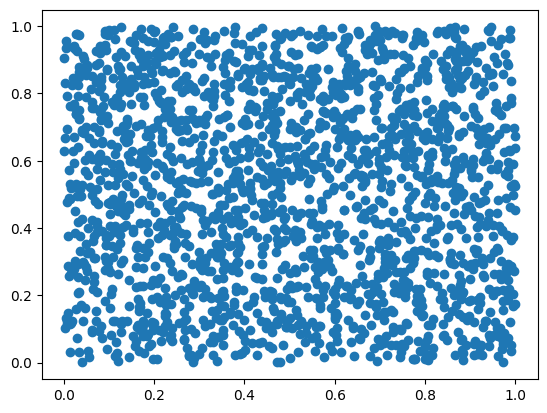

In [327]:
plt.scatter(ran['tws'][:2000], ran['precip'][:2000])

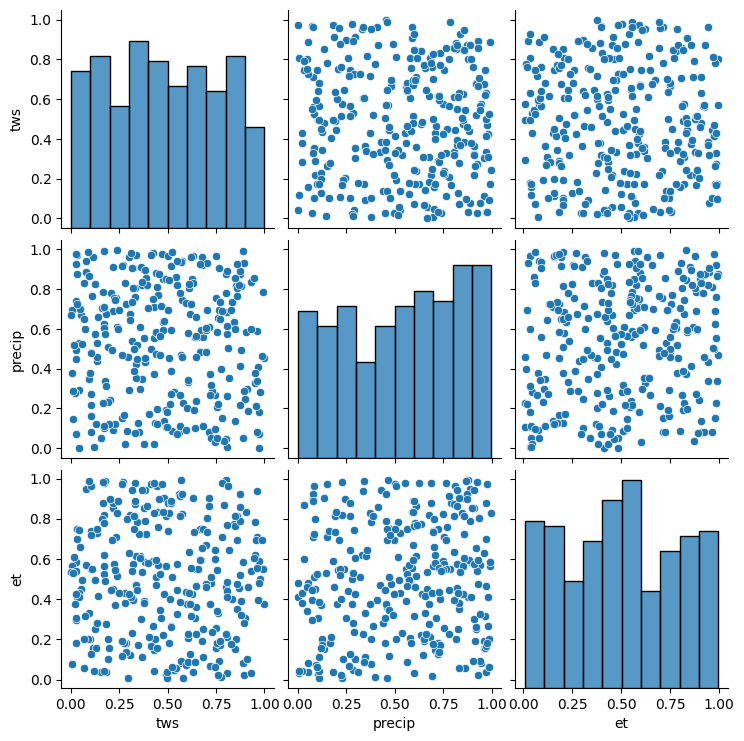

In [337]:
sns.pairplot(ran[:300])
plt.show()

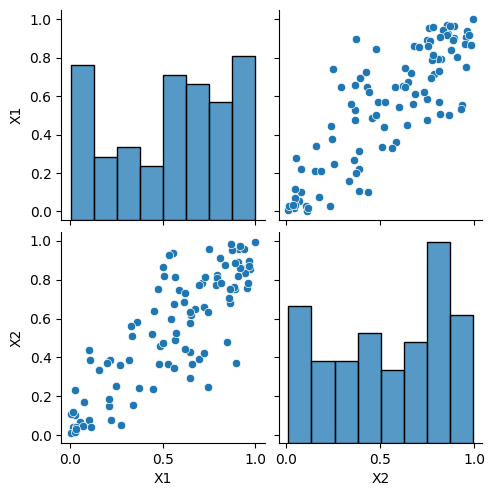

In [336]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copulae import GaussianCopula

# Example: Fit a Gaussian copula
data = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.8], [0.8, 1]], size=1000)
copula = GaussianCopula(dim=2)
copula.fit(data)

# Generate samples from the copula
samples = copula.random(100)

# Visualize the samples
sns.pairplot(pd.DataFrame(samples, columns=['X1', 'X2']))
plt.show()

In [176]:
# Example usage
first_subregion_id = list(subregion_datasets.keys())[0]
best_copula = lookup_best_copula(first_subregion_id)
new_drought_index = apply_best_copula(first_subregion_id)

Subregion 1.0:
Best Copula: Gaussian
Log-Likelihood: 62230.99
AIC: -124455.98
BIC: -124419.55
Parameters: [0.06915878 0.28476277 0.00718232]
Drought index recomputed for subregion 1.0 using GaussianCopula


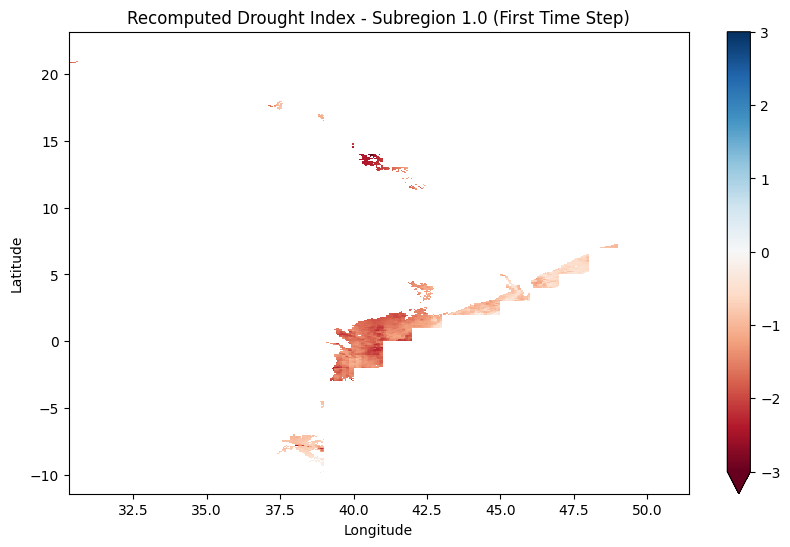

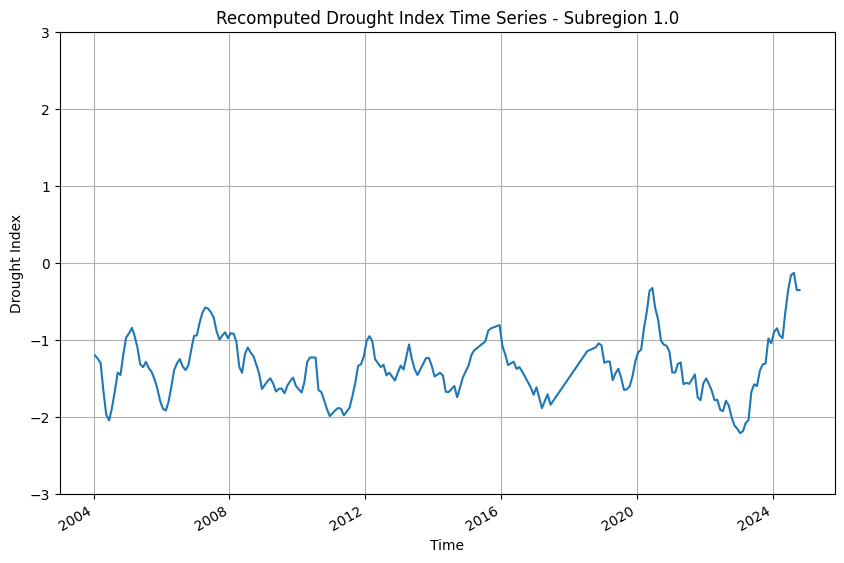

In [190]:
# Visualize
plt.figure(figsize=(10, 6))
new_drought_index.isel(time=1).plot(cmap='RdBu', vmin=-3, vmax=3)
plt.title(f"Recomputed Drought Index - Subregion {first_subregion_id} (First Time Step)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

plt.figure(figsize=(10, 6))
apply_ema(new_drought_index, span=6).mean(dim=['y', 'x']).plot()
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index")
plt.ylim(-3, 3)  # Set y-axis limits to -3 and 3
plt.grid(True)
plt.show()

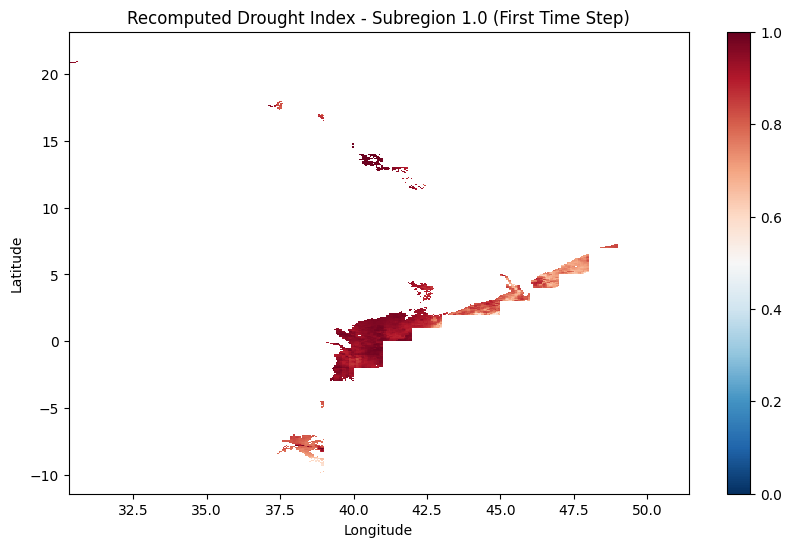

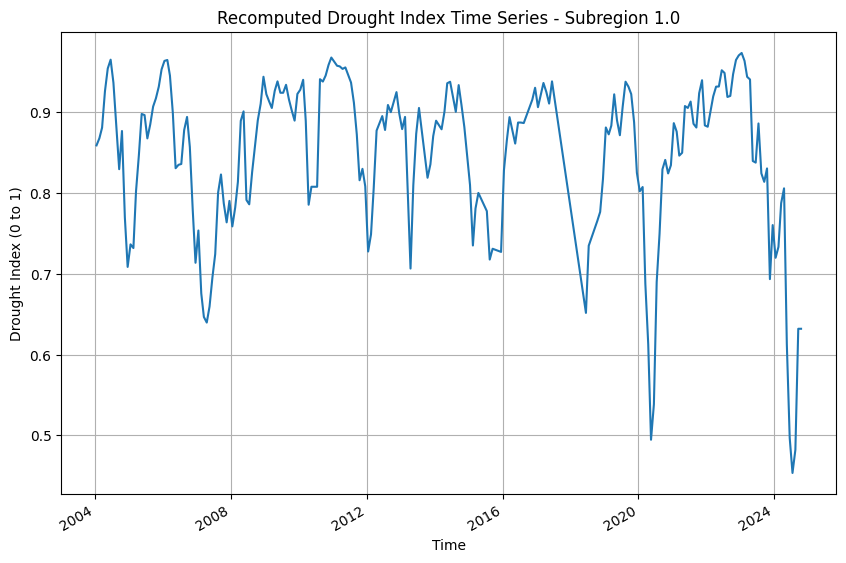

In [495]:
# Visualize
plt.figure(figsize=(10, 6))
new_drought_index.isel(time=1).plot(cmap='RdBu_r', vmin=0, vmax=1)
plt.title(f"Recomputed Drought Index - Subregion {first_subregion_id} (First Time Step)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

plt.figure(figsize=(10, 6))
apply_ema(new_drought_index, span=3).mean(dim=['y', 'x']).plot()
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index (0 to 1)")
plt.grid(True)
plt.show()

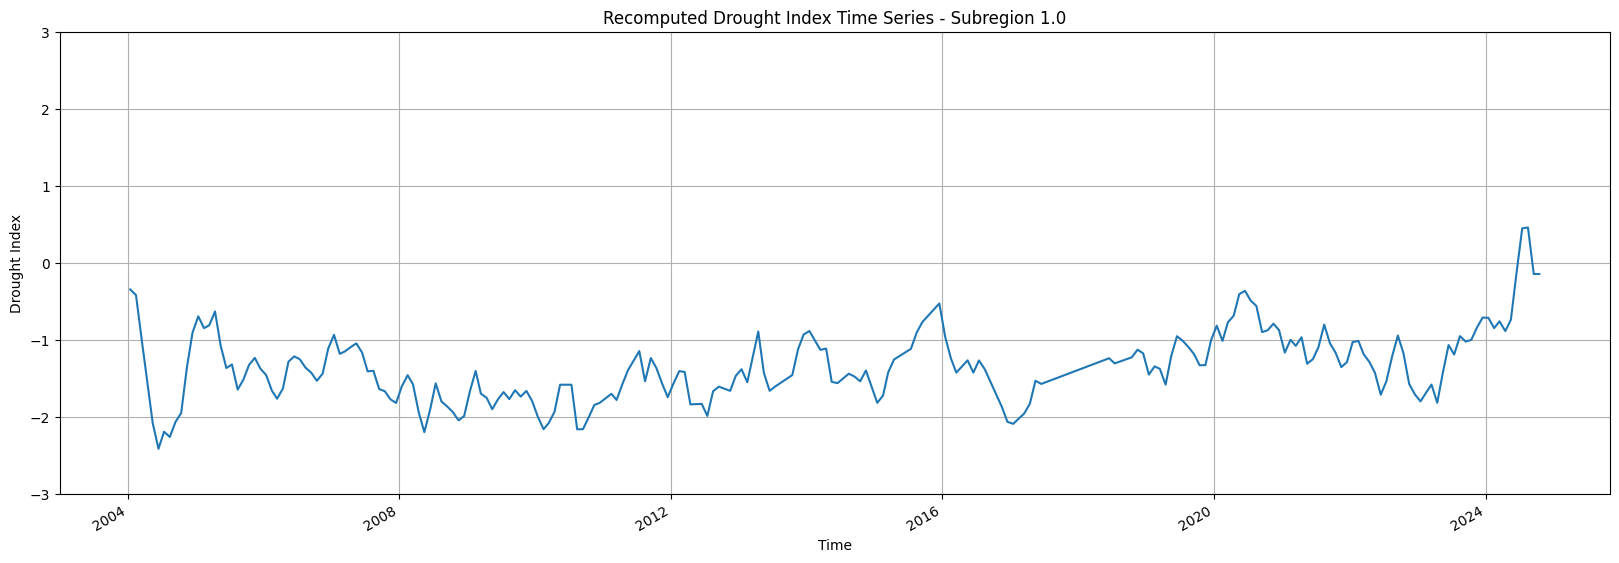

In [218]:
plt.figure(figsize=(20, 6))
apply_ema(new_drought_index, span=6).sel(y=5, x=47.5, method="nearest").plot()
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index")
plt.ylim(-3, 3)  # Set y-axis limits to -3 and 3
plt.grid(True)
plt.show()

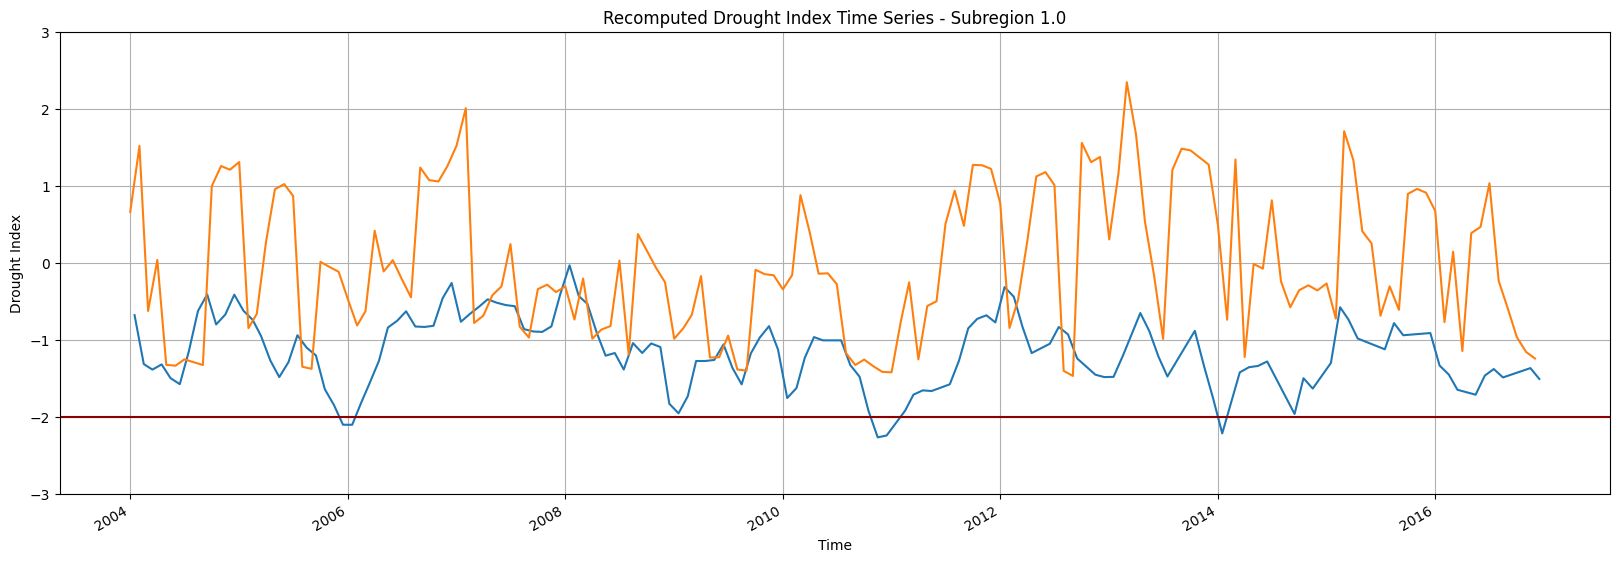

In [221]:
plt.figure(figsize=(20, 6))
apply_ema(new_drought_index.sel(time=slice('2004-01-01', '2016-12-31')), span=3).sel(y=0, x=40, method="nearest").plot(label="GHDI")
spei03.sel(lat=5, lon=47.5, method="nearest").plot(label="SPEI-03")
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index")
plt.ylim(-3, 3)  # Set y-axis limits to -3 and 3
plt.axhline(y=-2, color='darkred')
plt.grid(True)
plt.show()

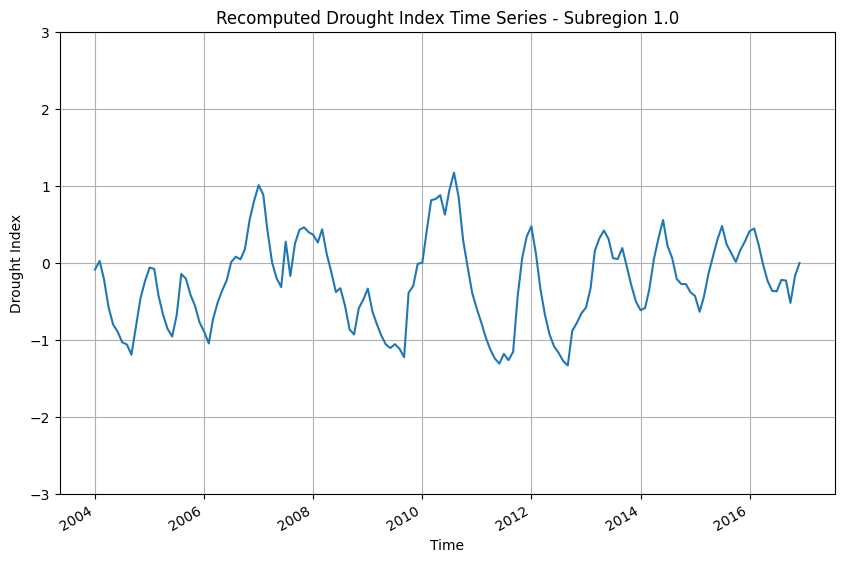

In [214]:
plt.figure(figsize=(10, 6))
# apply_ema(new_drought_index, span=6).sel(y=0, x=40, method="nearest").plot(label="GHDI")
apply_ema(spei03, span=6).sel(lat=0, lon=40, method="nearest").plot(label="SPEI-03")
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index")
plt.ylim(-3, 3)  # Set y-axis limits to -3 and 3
plt.grid(True)
plt.show()

In [202]:
spei03 = xr.open_dataset(os.path.join(dataset, 'validation_datasets/spei03.nc')).spei.sel(time=slice('2004-01-01', None))
spei03

<xarray.DataArray 'spei' (time: 156, lat: 1800, lon: 2080)>
[584064000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 47.97 47.92 47.88 47.83 ... -41.88 -41.92 -41.97
  * lon      (lon) float32 -27.98 -27.92 -27.88 -27.83 ... 75.88 75.93 75.97
  * time     (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2016-12-01
Attributes:
    units:      z value
    long_name:  Standardized Precipitation Evapotranspiration Index

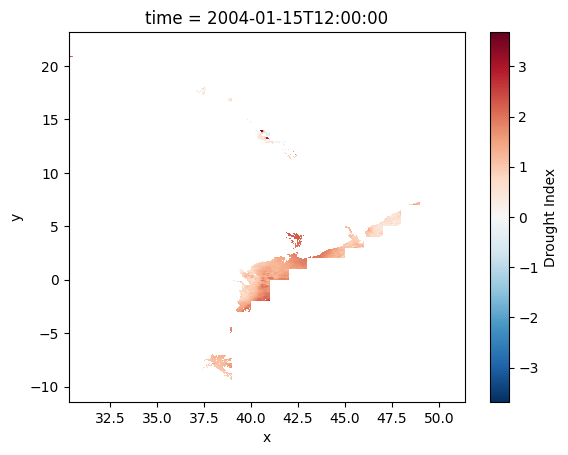

In [474]:
stand.isel(time=0).plot()

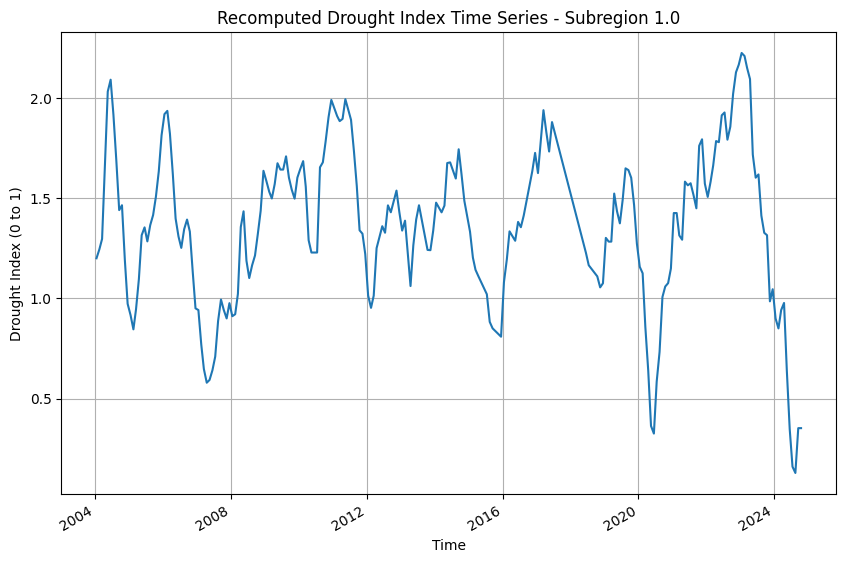

In [493]:
plt.figure(figsize=(10, 6))
apply_ema(stand, span=6).mean(dim=['y', 'x']).plot()
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index (0 to 1)")
plt.grid(True)
plt.show()

In [497]:
# Example usage
fteen_subregion_id = list(subregion_datasets.keys())[13]
best_copula_14 = lookup_best_copula(fteen_subregion_id)
new_drought_index_14 = apply_best_copula(fteen_subregion_id)

Subregion 14.0:
Best Copula: Gaussian
Log-Likelihood: 1115.14
AIC: -2224.28
BIC: -2190.98
Parameters: [-0.02276805 -0.04167455  0.04874515]
Drought index recomputed for subregion 14.0 using GaussianCopula


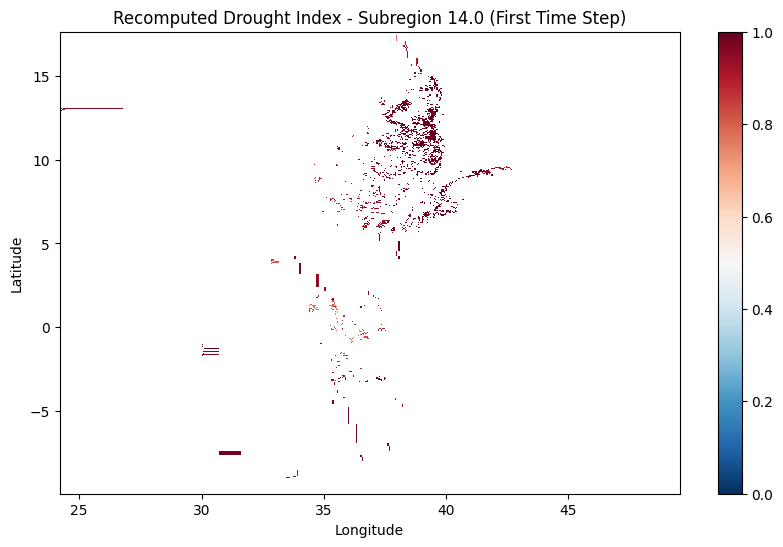

In [482]:
plt.figure(figsize=(10, 6))
new_drought_index_14.isel(time=1).plot(cmap='RdBu_r', vmin=0, vmax=1)
plt.title(f"Recomputed Drought Index - Subregion {fteen_subregion_id} (First Time Step)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

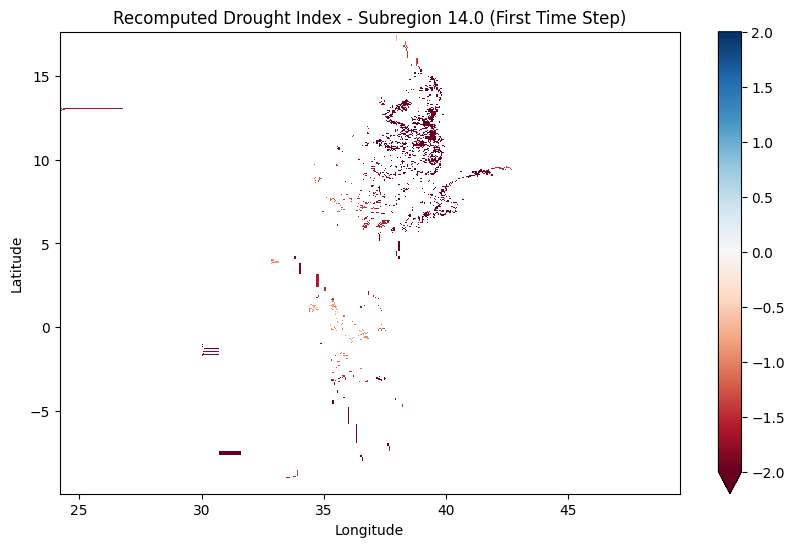

In [509]:
plt.figure(figsize=(10, 6))
new_drought_index_14.isel(time=1).plot(cmap='RdBu',  vmin=-2, vmax=2)
plt.title(f"Recomputed Drought Index - Subregion {fteen_subregion_id} (First Time Step)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

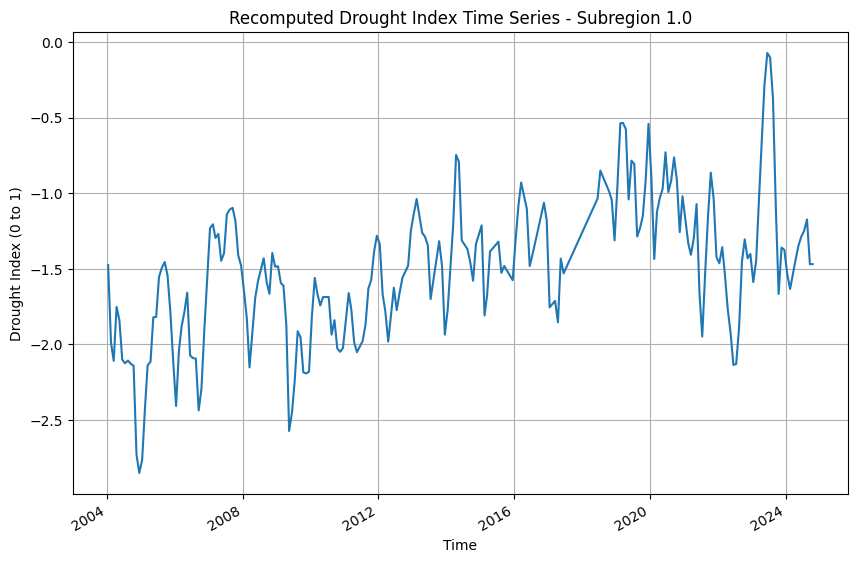

In [502]:
plt.figure(figsize=(10, 6))
apply_ema(new_drought_index_14, span=3).mean(dim=['y', 'x']).plot()
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index (0 to 1)")
plt.grid(True)
plt.show()

In [510]:
new = new_drought_index_14.combine_first(new_drought_index)

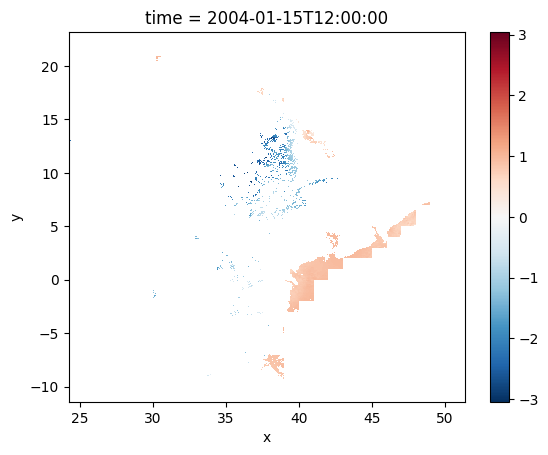

In [511]:
new.isel(time=0).plot()

In [516]:
drought_list = []
for subregion_id in subregion_datasets:
    drought_list.append(apply_best_copula(subregion_id))
    
drought_list

Drought index recomputed for subregion 1.0 using GaussianCopula
Drought index recomputed for subregion 2.0 using ClaytonCopula
Drought index recomputed for subregion 3.0 using GumbelCopula
Drought index recomputed for subregion 4.0 using GaussianCopula
Drought index recomputed for subregion 5.0 using GumbelCopula
Drought index recomputed for subregion 6.0 using GaussianCopula
Drought index recomputed for subregion 7.0 using GumbelCopula
Drought index recomputed for subregion 8.0 using GumbelCopula
Drought index recomputed for subregion 9.0 using GaussianCopula
Drought index recomputed for subregion 10.0 using GumbelCopula
Drought index recomputed for subregion 11.0 using GaussianCopula
Drought index recomputed for subregion 12.0 using GumbelCopula
Drought index recomputed for subregion 13.0 using ClaytonCopula
Drought index recomputed for subregion 14.0 using GaussianCopula
Drought index recomputed for subregion 15.0 using GaussianCopula


[<xarray.DataArray (time: 219, y: 671, x: 337)>
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
 ...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
        

In [224]:
drought_list = []
for subregion_id in subregion_datasets:
    drought_list.append(apply_best_copula(subregion_id))

Drought index recomputed for subregion 1.0 using GaussianCopula
Drought index recomputed for subregion 2.0 using ClaytonCopula
Drought index recomputed for subregion 3.0 using GumbelCopula
Drought index recomputed for subregion 4.0 using GaussianCopula
Drought index recomputed for subregion 5.0 using GumbelCopula
Drought index recomputed for subregion 6.0 using GaussianCopula
Drought index recomputed for subregion 7.0 using GumbelCopula
Drought index recomputed for subregion 8.0 using ClaytonCopula
Drought index recomputed for subregion 9.0 using GaussianCopula


In [257]:
on = drought_list[0].combine_first(drought_list[1])

In [269]:
on = on.combine_first(drought_list[8])

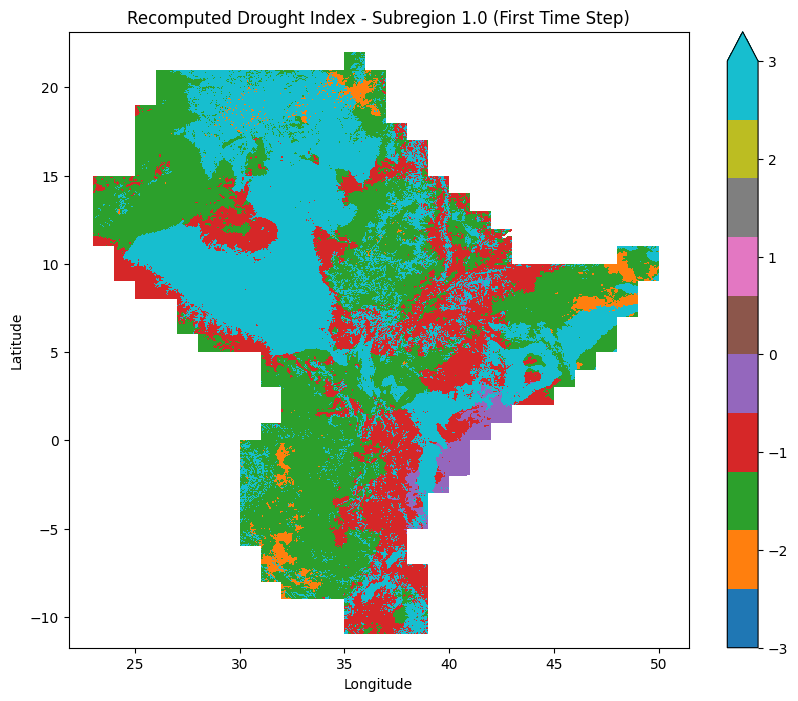

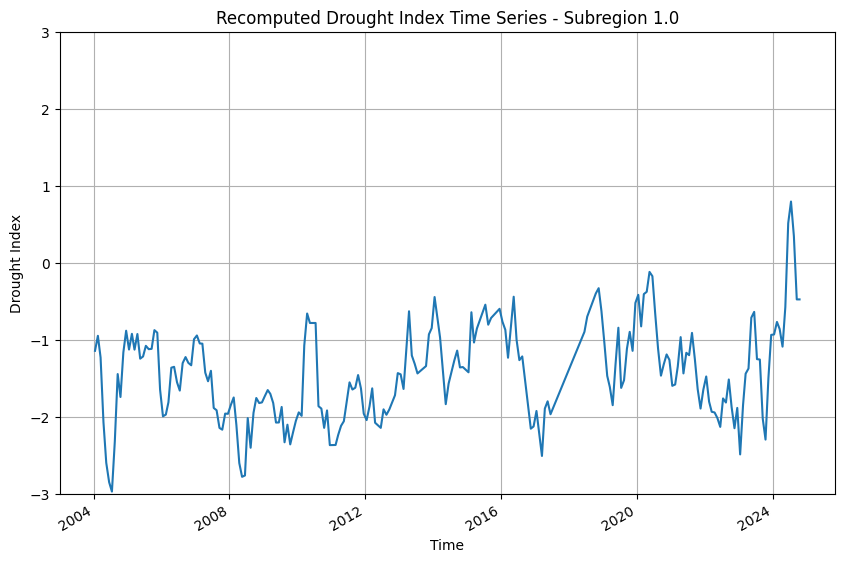

In [286]:
# Visualize
plt.figure(figsize=(10, 8))
on.sel(time=slice("2007-01-01", "2007-12-31")).mean(dim="time").plot(cmap='tab10', vmin=-3, vmax=3)
plt.title(f"Recomputed Drought Index - Subregion {first_subregion_id} (First Time Step)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

plt.figure(figsize=(10, 6))
apply_ema(on, span=3).sel(y=6, x=45, method="nearest").plot()
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index")
plt.ylim(-3, 3)  # Set y-axis limits to -3 and 3
plt.grid(True)
plt.show()

In [304]:
on.to_netcdf(os.path.join(dataset, 'results/ghdi.nc'))

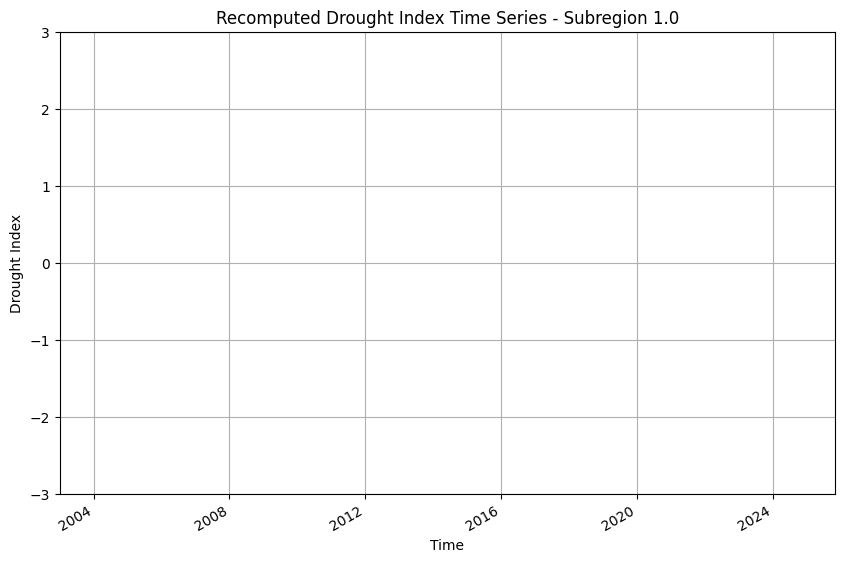

In [287]:
plt.figure(figsize=(10, 6))
apply_ema(on, span=3).sel(y=9, x=30, method="nearest").plot()
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index")
plt.ylim(-3, 3)  # Set y-axis limits to -3 and 3
plt.grid(True)
plt.show()

In [256]:
# Combine all DataArrays into a single DataArray
combined_drought = xr.combine_by_coords([i for i in drought_list])

# Optional: Rename the variable for clarity
combined_drought = combined_drought.rename("drought_index")

print(combined_drought)

ValueError: cannot reindex or align along dimension 'y' because the (pandas) index has duplicate values

In [251]:
import xarray as xr

# Create a dictionary mapping subregion IDs to DataArrays
drought_dict = {subregion_id: da for subregion_id, da in zip(subregion_datasets.keys(), drought_list)}

# Combine into a Dataset with a subregion dimension
combined_dataset = xr.Dataset(drought_dict)  # Adjust variable name if needed

# Optional: Assign a coordinate to the subregion dimension
combined_dataset = combined_dataset.assign_coords(subregion=list(subregion_datasets.keys()))

print(combined_dataset)

<xarray.Dataset>
Dimensions:    (time: 219, y: 698, x: 591, subregion: 9)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:00:00
  * y          (y) float64 -11.73 -11.68 -11.63 -11.58 ... 23.02 23.07 23.12
  * x          (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38
  * subregion  (subregion) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0
Data variables:
    1.0        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    2.0        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    3.0        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    4.0        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    5.0        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    6.0        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    7.0        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    8.0        (time, y, x) f

In [345]:
drought_list[1]

<xarray.DataArray (time: 219, y: 686, x: 543)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:00:00
  * y        (y) float64 22.87 22.82 22.77 22.72 ... -11.58 -11.63 -11.68 -11.73
  * x        (x) float64 23.28 23.33 23.38 23.43 ... 50.83 50.88 50.93 50.98

In [253]:
combined_dataset['1.0'].isel(time=3).plot(cmap='RdBu')
plt.title(f"Recomputed Drought Index - Subregion {fteen_subregion_id} (First Time Step)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

KeyError: '1'

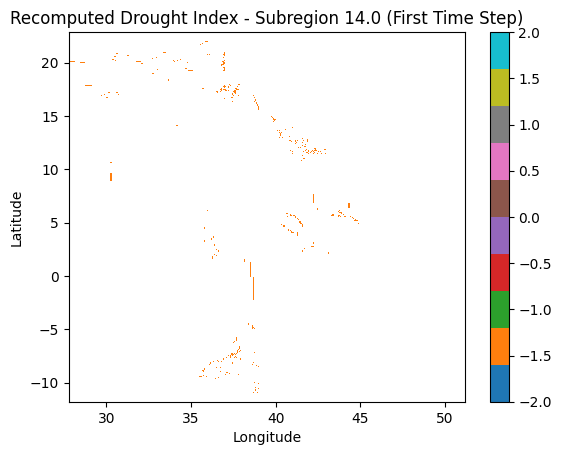

In [576]:
drought_list[10].mean(dim='time').plot(cmap='tab10', vmin=-2, vmax=2)
plt.title(f"Recomputed Drought Index - Subregion {fteen_subregion_id} (First Time Step)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [487]:
# Initialize an empty dataset with the full grid
full_drought_index = xr.full_like(full_ghdi['et'].isel(time=0), np.nan)

# Fill in each subregion
for subregion_id, ds in subregion_datasets.items():
    
    subregion_mask = full_ghdi['landform'] == subregion_id
    full_drought_index = full_drought_index.where(~subregion_mask, ds['drought_index'])

# Add to combined dataset
full_ghdi['drought_index'] = full_drought_index

# Save or analyze the result
# combined_ds.to_netcdf('drought_index_gha.nc')
print(full_ghdi['drought_index'])

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'y' ('y',)

In [485]:
full_ghdi

<xarray.Dataset>
Dimensions:      (time: 219, y: 698, x: 591)
Coordinates:
  * time         (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:...
    lat          (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
    lon          (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38
    band         int64 1
  * y            (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
  * x            (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38
    spatial_ref  int64 0
Data variables:
    tws          (y, x, time) float64 nan nan nan nan nan ... nan nan nan nan
    precip       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    et           (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    landform     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

#### Copula Analysis with copulae Module

In [136]:
# Function to test and select the best copula
def fit_best_copula(tws_cdf, precip_cdf, et_cdf):
    # Combine CDFs into a DataFrame (copulae expects a 2D array)
    data = np.vstack([tws_cdf, precip_cdf, et_cdf]).T
    data_df = pd.DataFrame(data, columns=['tws', 'precip', 'et'])
    
    # List of copulas to test
    copulas = {
        'Gaussian': GaussianCopula(dim=3),
        'Clayton': ClaytonCopula(dim=3),
        'Frank': FrankCopula(dim=3),
        'Gumbel': GumbelCopula(dim=3)
    }
    
    # Dictionary to store fit results
    fit_results = {}
    
    # Fit each copula and compute AIC
    for name, copula in copulas.items():
        try:
            copula.fit(data_df)
            log_likelihood = copula.log_lik(data_df)
            n_params = len(copula.params)  # Number of parameters in the copula
            aic = -2 * log_likelihood + 2 * n_params  # AIC formula
            fit_results[name] = {'copula': copula, 'aic': aic}
        except Exception as e:
            print(f"Error fitting {name} copula: {e}")
            fit_results[name] = {'copula': None, 'aic': np.inf}
    
    # Select the best copula (lowest AIC)
    best_copula_name = min(fit_results, key=lambda x: fit_results[x]['aic'])
    best_copula = fit_results[best_copula_name]['copula']
    print(f"Best copula for subregion: {best_copula_name} (AIC: {fit_results[best_copula_name]['aic']})")
    
    return best_copula

In [227]:
best_copulas

{1.0: <copulae.elliptical.gaussian.GaussianCopula at 0x7f8c6223cc10>,
 2.0: <copulae.archimedean.clayton.ClaytonCopula at 0x7f8c62406670>,
 3.0: <copulae.archimedean.gumbel.GumbelCopula at 0x7f8c622450d0>,
 4.0: <copulae.elliptical.gaussian.GaussianCopula at 0x7f8c6244afa0>,
 5.0: <copulae.archimedean.gumbel.GumbelCopula at 0x7f8c6228e0a0>,
 6.0: <copulae.elliptical.gaussian.GaussianCopula at 0x7f8c62217340>,
 7.0: <copulae.archimedean.gumbel.GumbelCopula at 0x7f8c622b12e0>,
 8.0: <copulae.archimedean.clayton.ClaytonCopula at 0x7f8c621dc7c0>,
 9.0: <copulae.elliptical.gaussian.GaussianCopula at 0x7f8c621dc400>}

In [134]:
# Function to compute drought index using the best copula
def compute_copula_index(ds):
    # Stack CDFs and drop NaNs
    stacked_data = xr.Dataset({
        'tws_cdf': ds['tws_cdf'],
        'precip_cdf': ds['precip_cdf'],
        'et_cdf': ds['et_cdf']
    }).stack(all_points=['time', 'y', 'x']).dropna(dim='all_points')
    
    # Extract CDF values
    tws_cdf = stacked_data['tws_cdf'].values
    precip_cdf = stacked_data['precip_cdf'].values
    et_cdf = stacked_data['et_cdf'].values
    
    # Fit the best copula
    best_copula = fit_best_copula(tws_cdf, precip_cdf, et_cdf)
    
    # Compute joint CDF using the best copula
    data_for_cdf = pd.DataFrame({
        'tws': tws_cdf,
        'precip': precip_cdf,
        'et': et_cdf
    })
    joint_cdf = best_copula.cdf(data_for_cdf)
    
    # Drought index: Invert joint CDF (higher values = worse drought)
    drought_index = 1 - joint_cdf
    
    # Reconstruct as DataArray
    return xr.DataArray(
        drought_index,
        coords={'all_points': stacked_data.coords['all_points']},
        dims=['all_points']
    ).unstack(), best_copula



In [137]:
# Apply to each subregion and store the best copula
best_copulas = {}  # To store the best copula for each subregion
for subregion_id, ds in subregion_datasets.items():
    ds['drought_index'], best_copula = compute_copula_index(ds)
    subregion_datasets[subregion_id] = ds
    best_copulas[subregion_id] = best_copula
    
    # Example output
    print(f"Subregion {subregion_id} drought index computed.")

# Example: Check drought index for the first subregion
print(subregion_datasets[first_subregion_id]['drought_index'])

                tws        precip            et
count  1.390176e+06  1.390176e+06  1.390176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    7.193329e-07  7.193329e-07  7.193329e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999993e-01  9.999993e-01  9.999993e-01
                tws        precip            et
count  1.390176e+06  1.390176e+06  1.390176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    7.193329e-07  7.193329e-07  7.193329e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999993e-01  9.999993e-01  9.999993e-01
Error fitting Clayton copula: object of type 'float' has no len()
                tws        precip            et
count  1.390176e+06  1

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                tws        precip            et
count  1.390176e+06  1.390176e+06  1.390176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    7.193329e-07  7.193329e-07  7.193329e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999993e-01  9.999993e-01  9.999993e-01


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Error fitting Gumbel copula: object of type 'float' has no len()
Best copula for subregion: Gaussian (AIC: -124455.97989720064)


IOStream.flush timed out


Subregion 1.0 drought index computed.
                tws        precip            et
count  1.183291e+07  1.183291e+07  1.183291e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    8.451004e-08  8.451004e-08  8.451004e-08
25%    2.500000e-01  2.500000e-01  2.500000e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.500000e-01  7.500000e-01  7.500000e-01
max    9.999999e-01  9.999999e-01  9.999999e-01
                tws        precip            et
count  1.183291e+07  1.183291e+07  1.183291e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    8.451004e-08  8.451004e-08  8.451004e-08
25%    2.500000e-01  2.500000e-01  2.500000e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.500000e-01  7.500000e-01  7.500000e-01
max    9.999999e-01  9.999999e-01  9.999999e-01
Error fitting Clayton copula: object of type 'float' has no len()



KeyboardInterrupt



In [1]:
subregion_datasets[first_subregion_id]['drought_index'].isel(time=44).plot()

NameError: name 'subregion_datasets' is not defined

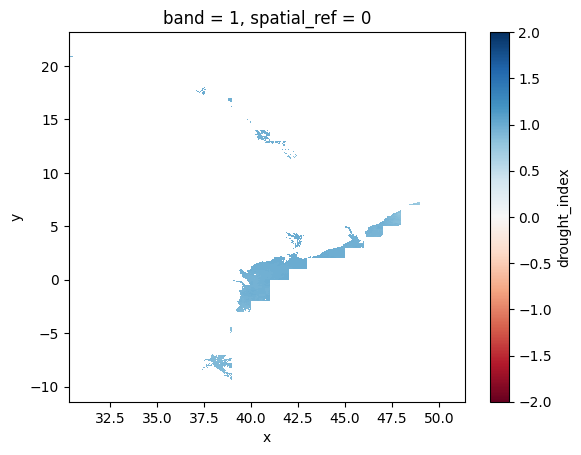

In [142]:
subregion_datasets[first_subregion_id]['drought_index'].sel(time=slice("2011-01-01", "2011-05-31")).mean(dim="time").plot(
    robust=True, cmap="RdBu", vmin=-2, vmax=2)

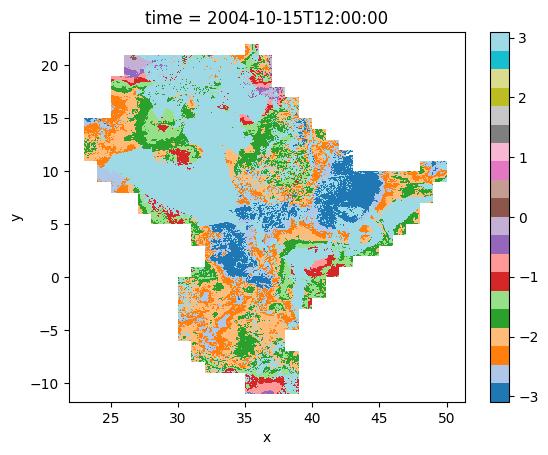

In [358]:
on.isel(time=9).plot(cmap='tab20')

In [350]:
# Example drought index (replace with your actual data)
dates = pd.date_range(start='2004-01-01', end='2023-01-01', freq='M')
drought_index = pd.Series(np.random.uniform(0, 1, len(dates)), index=dates)

In [351]:
drought_threshold = 0.4  # From your example for moderate drought
min_duration_months = 3  # Minimum duration for a drought event
recovery_period_months = 1  # Minimum period to confirm recovery

In [353]:
drought_events = []
in_drought = False
start_idx = None
current_run = []

for i, value in enumerate(on):
    if value < drought_threshold and not in_drought:
        start_idx = i
        in_drought = True
        current_run = [value]
    elif value < drought_threshold and in_drought:
        current_run.append(value)
    elif value >= drought_threshold and in_drought:
        # Check if the run meets the minimum duration
        if len(current_run) >= min_duration:
            # Calculate run sum (severity as cumulative deficit)
            run_sum = np.sum(drought_threshold - np.array(current_run))
            # Check recovery period
            if i + recovery_period <= len(drought_index):
                end_check = drought_index[i:i + recovery_period]
                if all(end_check >= drought_threshold):
                    end_idx = i - 1  # End of the drought run
                    drought_events.append({
                        'Start_Index': start_idx,
                        'End_Index': end_idx,
                        'Duration': len(current_run),  # In time steps
                        'Severity': run_sum  # Cumulative deficit
                    })
        in_drought = False
        current_run = []

# Convert to DataFrame for easier analysis
import pandas as pd
drought_df = pd.DataFrame(drought_events)
print(drought_df)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [17]:
ghdi = (os.path.join(dataset, 'results/ghdi.nc'))
ghdi

'../../datasets/results/ghdi.nc'

In [19]:
ghadi = xr.open_dataset(ghdi)

In [24]:
ghadi.__xarray_dataarray_variable__

<xarray.DataArray '__xarray_dataarray_variable__' (time: 219, y: 698, x: 591)>
[90341442 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:00:00
  * y        (y) float64 -11.73 -11.68 -11.63 -11.58 ... 22.97 23.02 23.07 23.12
  * x        (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38

In [40]:
com = xr.open_dataset(os.path.join(dataset, 'combined_data.nc'))

In [41]:
com.data_vars

Data variables:
    tws       (y, x, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    precip    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    et        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    landform  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

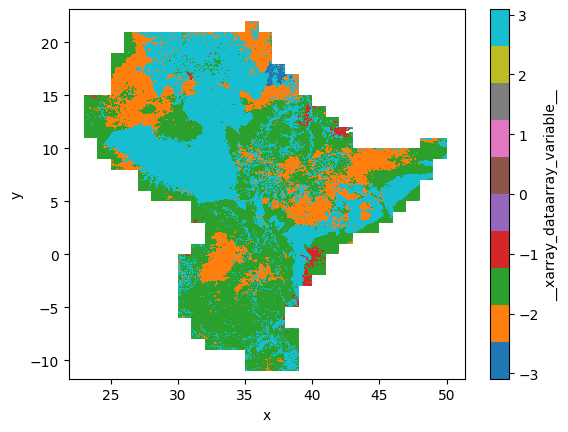

In [38]:
drought_2011 = ghadi['__xarray_dataarray_variable__'].sel(time=slice("2011-01-01", "2011-12-31")).mean(dim="time")
drought_2011.rio.to_raster(os.path.join(dataset, 'results/drought_2011.tif'))

drought_2011.plot(
    robust=True, cmap="tab10"
)

## Old Approach

### Regional Anomalies

In [ ]:
def standardized_anomaly(data):
    # Compute monthly climatology
    climatology = data.groupby('time.month').mean(dim='time')
    # Compute standard deviation
    std_dev = data.groupby('time.month').std(dim='time')
    
    # Compute anomaly
    anomaly = data.groupby('time.month') - climatology
    # Standardize anomaly
    standardized_anomaly = anomaly / std_dev
    
    return standardized_anomaly

# Compute standardized anomalies for each dataset
et_anomaly = standardized_anomaly(et_data)
precipitation_anomaly = standardized_anomaly(precipitation_data)
tws_anomaly = standardized_anomaly(tws_data)

In [679]:
# Loop through each subregion
for class_value in subregion_data:
    # Extract raw data for the subregion
    tws = subregion_data[class_value]["tws"]
    et = subregion_data[class_value]["et"]
    precip = subregion_data[class_value]["precip"]

    tws_mean = tws.groupby("time.month").mean("time", skipna=True)
    tws_std = tws.groupby("time.month").std("time", skipna=True)
    
    et_mean = et.groupby("time.month").mean("time", )
    et_std = et.groupby("time.month").std("time", )
    
    precip_mean = precip.groupby("time.month").mean("time", skipna=True)
    precip_std = precip.groupby("time.month").std("time", skipna=True)
    
    # Calculate monthly anomalies
    tws_anomaly = tws.groupby("time.month") - tws_mean
    et_anomaly = et.groupby("time.month") - et_mean
    precip_anomaly = precip.groupby("time.month") - precip_mean

    # Calculate standardized anomalies
    tws_st_anomaly = tws_anomaly / tws_std
    et_st_anomaly = et_anomaly / et_std
    precip_st_anomaly = precip_anomaly / precip_std

    # Store the anomalies
    subregion_data[class_value]["tws_anomaly"] = tws_st_anomaly
    subregion_data[class_value]["et_anomaly"] = et_st_anomaly
    subregion_data[class_value]["precip_anomaly"] = precip_st_anomaly

In [667]:
tq = np.sort(subregion_data_new[1]['tws_anomaly'].values[~np.isnan(subregion_data_new[1]['tws_anomaly'].values)])
print(t)

[-7.83476469 -7.8268617  -7.73760702 ...  6.15291829  6.15577158
  6.16053542]


In [680]:
tqm = np.sort(subregion_data[1]['tws_anomaly'].values[~np.isnan(subregion_data[1]['tws_anomaly'].values)])
print(t)

[-7.83476469 -7.8268617  -7.73760702 ...  6.15291829  6.15577158
  6.16053542]


In [677]:
len(subregion_data_new[1]['tws_anomaly'])

671

In [668]:
# Subregion 1 (class_value = 1)
tws_anomaly_1 = subregion_data[1]["tws_anomaly"].values.flatten()
et_anomaly_1 = subregion_data[1]["et_anomaly"].values.flatten()
precip_anomaly_1 = subregion_data[1]["precip_anomaly"].values.flatten()

# Remove NaNs for class 1
# valid_1 = ~np.isnan(tws_anomaly_1) & ~np.isnan(et_anomaly_1) & ~np.isnan(precip_anomaly_1)
tws_anomaly_1 = tws_anomaly_1[~np.isnan(tws_anomaly_1)]
et_anomaly_1 = et_anomaly_1[~np.isnan(et_anomaly_1)]
precip_anomaly_1 = precip_anomaly_1[~np.isnan(precip_anomaly_1)]

In [669]:
print(tws_anomaly_1.shape, et_anomaly_1.shape, precip_anomaly_1.shape)

(1410141,) (2638720,) (2806096,)


In [514]:
# Subregion 1 (class_value = 1)
tws_anomaly_1 = subregion_data[1]["tws_anomaly_q"].values.flatten()
et_anomaly_1 = subregion_data[1]["et_anomaly_q"].values.flatten()
precip_anomaly_1 = subregion_data[1]["precip_anomaly_q"].values.flatten()

# Remove NaNs for class 1
valid_1 = ~np.isnan(tws_anomaly_1) & ~np.isnan(et_anomaly_1) & ~np.isnan(precip_anomaly_1)
tws_anomaly_1 = tws_anomaly_1[valid_1]
et_anomaly_1 = et_anomaly_1[valid_1]
precip_anomaly_1 = precip_anomaly_1[valid_1]

In [106]:
print(tws_anomaly_1.shape, et_anomaly_1.shape, precip_anomaly_1.shape)

NameError: name 'tws_anomaly_1' is not defined

In [681]:
# Subregion 1 (class_value = 1)
tws_anomaly_1 = subregion_data[1]["tws_anomaly"].values.flatten()
et_anomaly_1 = subregion_data[1]["et_anomaly"].values.flatten()
precip_anomaly_1 = subregion_data[1]["precip_anomaly"].values.flatten()

# Remove NaNs for class 1
valid_1 = ~np.isnan(tws_anomaly_1) & ~np.isnan(et_anomaly_1) & ~np.isnan(precip_anomaly_1)
tws_anomaly_1 = tws_anomaly_1[valid_1]
et_anomaly_1 = et_anomaly_1[valid_1]
precip_anomaly_1 = precip_anomaly_1[valid_1]

In [682]:
print(tws_anomaly_1.shape, et_anomaly_1.shape, precip_anomaly_1.shape)

(901260,) (901260,) (901260,)


In [ ]:
# Assuming landform_classes = [1, 2, 3] (adjust based on your data)
# Process each subregion separately

# Subregion 1 (class_value = 1)
tws_anomaly_1 = subregion_data[1]["tws_anomaly"].values.flatten()
et_anomaly_1 = subregion_data[1]["et_anomaly"].values.flatten()
precip_anomaly_1 = subregion_data[1]["precip_anomaly"].values.flatten()

# Remove NaNs for class 1
valid_1 = ~np.isnan(tws_anomaly_1) & ~np.isnan(et_anomaly_1) & ~np.isnan(precip_anomaly_1)
tws_anomaly_1 = tws_anomaly_1[valid_1]
et_anomaly_1 = et_anomaly_1[valid_1]
precip_anomaly_1 = precip_anomaly_1[valid_1]

# Transform to uniform [0,1] for class 1
u_tws_1 = stats.norm.cdf(tws_anomaly_1)
u_et_1 = stats.norm.cdf(et_anomaly_1)
u_precip_1 = stats.norm.cdf(precip_anomaly_1)

# Store transformed data for class 1
subregion_data[1]["u_tws"] = u_tws_1
subregion_data[1]["u_et"] = u_et_1
subregion_data[1]["u_precip"] = u_precip_1

# Subregion 2 (class_value = 2)
tws_anomaly_2 = subregion_data[2]["tws_anomaly"].values.flatten()
et_anomaly_2 = subregion_data[2]["et_anomaly"].values.flatten()
precip_anomaly_2 = subregion_data[2]["precip_anomaly"].values.flatten()

# Remove NaNs for class 2
valid_2 = ~np.isnan(tws_anomaly_2) & ~np.isnan(et_anomaly_2) & ~np.isnan(precip_anomaly_2)
tws_anomaly_2 = tws_anomaly_2[valid_2]
et_anomaly_2 = et_anomaly_2[valid_2]
precip_anomaly_2 = precip_anomaly_2[valid_2]

# Transform to uniform [0,1] for class 2
u_tws_2 = stats.norm.cdf(tws_anomaly_2)
u_et_2 = stats.norm.cdf(et_anomaly_2)
u_precip_2 = stats.norm.cdf(precip_anomaly_2)

# Store transformed data for class 2
subregion_data[2]["u_tws"] = u_tws_2
subregion_data[2]["u_et"] = u_et_2
subregion_data[2]["u_precip"] = u_precip_2

# Subregion 3 (class_value = 3)
tws_anomaly_3 = subregion_data[3]["tws_anomaly"].values.flatten()
et_anomaly_3 = subregion_data[3]["et_anomaly"].values.flatten()
precip_anomaly_3 = subregion_data[3]["precip_anomaly"].values.flatten()

# Remove NaNs for class 3
valid_3 = ~np.isnan(tws_anomaly_3) & ~np.isnan(et_anomaly_3) & ~np.isnan(precip_anomaly_3)
tws_anomaly_3 = tws_anomaly_3[valid_3]
et_anomaly_3 = et_anomaly_3[valid_3]
precip_anomaly_3 = precip_anomaly_3[valid_3]

# Transform to uniform [0,1] for class 3
u_tws_3 = stats.norm.cdf(tws_anomaly_3)
u_et_3 = stats.norm.cdf(et_anomaly_3)
u_precip_3 = stats.norm.cdf(precip_anomaly_3)

# Store transformed data for class 3
subregion_data[3]["u_tws"] = u_tws_3
subregion_data[3]["u_et"] = u_et_3
subregion_data[3]["u_precip"] = u_precip_3

# Optional: Print to compare at a glance
print("Subregion 1 - Mean u_tws:", u_tws_1.mean(), "u_et:", u_et_1.mean(), "u_precip:", u_precip_1.mean())
print("Subregion 2 - Mean u_tws:", u_tws_2.mean(), "u_et:", u_et_2.mean(), "u_precip:", u_precip_2.mean())
print("Subregion 3 - Mean u_tws:", u_tws_3.mean(), "u_et:", u_et_3.mean(), "u_precip:", u_precip_3.mean())

## Marginal Distribution

#### Clean data and stack

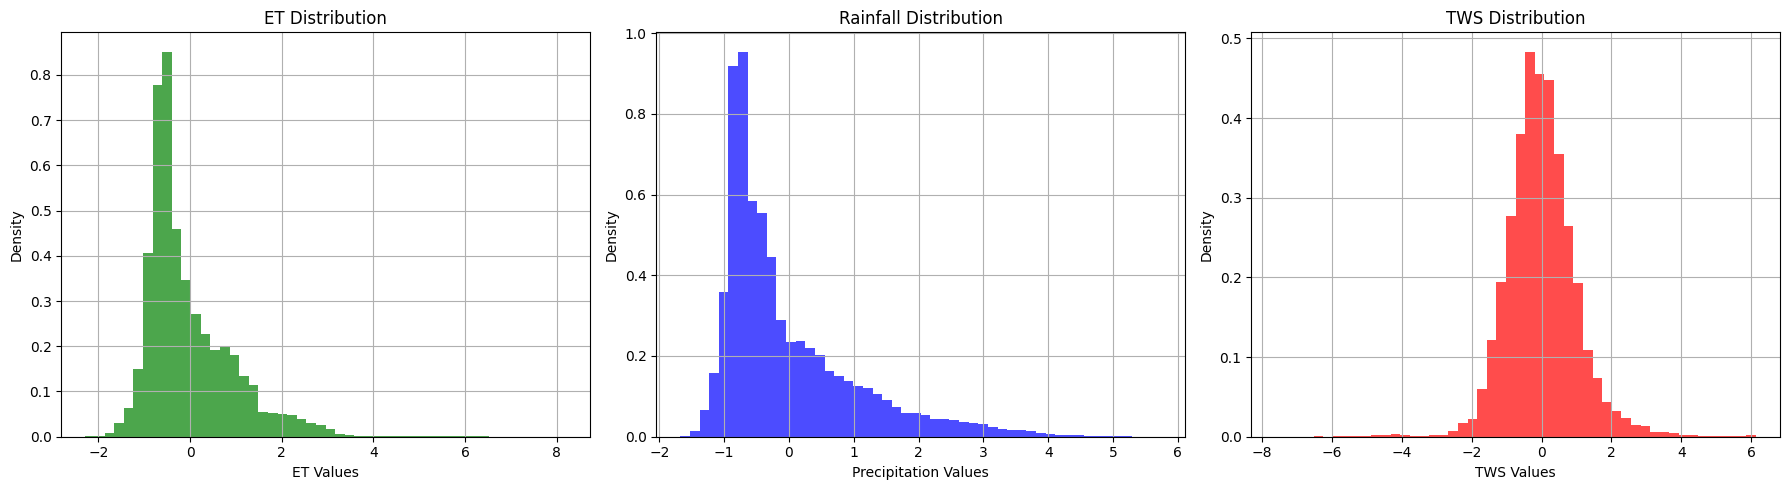

In [516]:
# Plot the histogram
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot ET Histogram
axes[0].hist(et_anomaly_1, bins=50, density=True, alpha=0.7, color='green')
axes[0].set_title("ET Distribution")
axes[0].set_xlabel("ET Values")
axes[0].set_ylabel("Density")
axes[0].grid(True)

# Plot Precipitation Histogram
axes[1].hist(precip_anomaly_1, bins=50, density=True, alpha=0.7, color='blue')
axes[1].set_title("Rainfall Distribution")
axes[1].set_xlabel("Precipitation Values")
axes[1].set_ylabel("Density")
axes[1].grid(True)

# Plot TWS Histogram
axes[2].hist(tws_anomaly_1, bins=50, density=True, alpha=0.7, color='red')
axes[2].set_title("TWS Distribution")
axes[2].set_xlabel("TWS Values")
axes[2].set_ylabel("Density")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


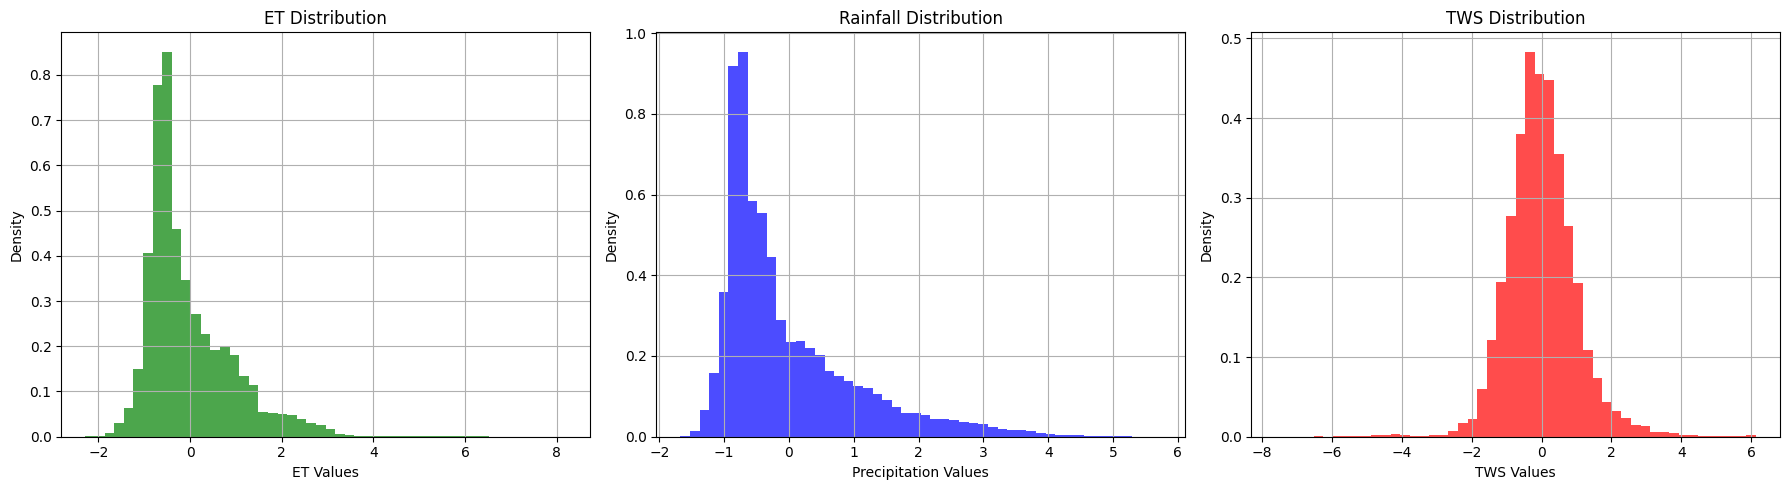

In [517]:
# Plot the histogram
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot ET Histogram
axes[0].hist(et_anomaly_1, bins=50, density=True, alpha=0.7, color='green')
axes[0].set_title("ET Distribution")
axes[0].set_xlabel("ET Values")
axes[0].set_ylabel("Density")
axes[0].grid(True)

# Plot Precipitation Histogram
axes[1].hist(precip_anomaly_1, bins=50, density=True, alpha=0.7, color='blue')
axes[1].set_title("Rainfall Distribution")
axes[1].set_xlabel("Precipitation Values")
axes[1].set_ylabel("Density")
axes[1].grid(True)

# Plot TWS Histogram
axes[2].hist(tws_anomaly_1, bins=50, density=True, alpha=0.7, color='red')
axes[2].set_title("TWS Distribution")
axes[2].set_xlabel("TWS Values")
axes[2].set_ylabel("Density")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Plot the histogram
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot ET Histogram
axes[0].hist(et_anomaly_1, bins=50, density=True, alpha=0.7, color='green')
axes[0].set_title("ET Distribution")
axes[0].set_xlabel("ET Values")
axes[0].set_ylabel("Density")
axes[0].grid(True)

# Plot Precipitation Histogram
axes[1].hist(precip_anomaly_1, bins=50, density=True, alpha=0.7, color='blue')
axes[1].set_title("Rainfall Distribution")
axes[1].set_xlabel("Precipitation Values")
axes[1].set_ylabel("Density")
axes[1].grid(True)

# Plot TWS Histogram
axes[2].hist(tws_anomaly_1, bins=50, density=True, alpha=0.7, color='red')
axes[2].set_title("TWS Distribution")
axes[2].set_xlabel("TWS Values")
axes[2].set_ylabel("Density")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [518]:
# Compute ECDF for ET
ecdf_et = ECDF(et_anomaly_1)

# Compute ECDF for Precipitation
ecdf_precip = ECDF(precip_anomaly_1)

# Compute ECDF for TWS
ecdf_twsa = ECDF(tws_anomaly_1)


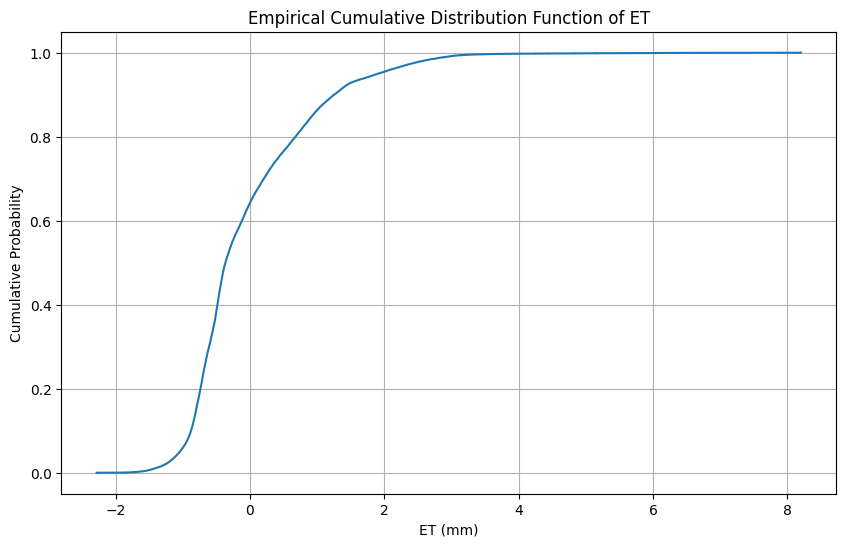

In [519]:
plt.figure(figsize=(10, 6))
plt.step(ecdf_et.x, ecdf_et.y, where='post')
plt.xlabel('ET (mm)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution Function of ET')
plt.grid(True)
plt.show()

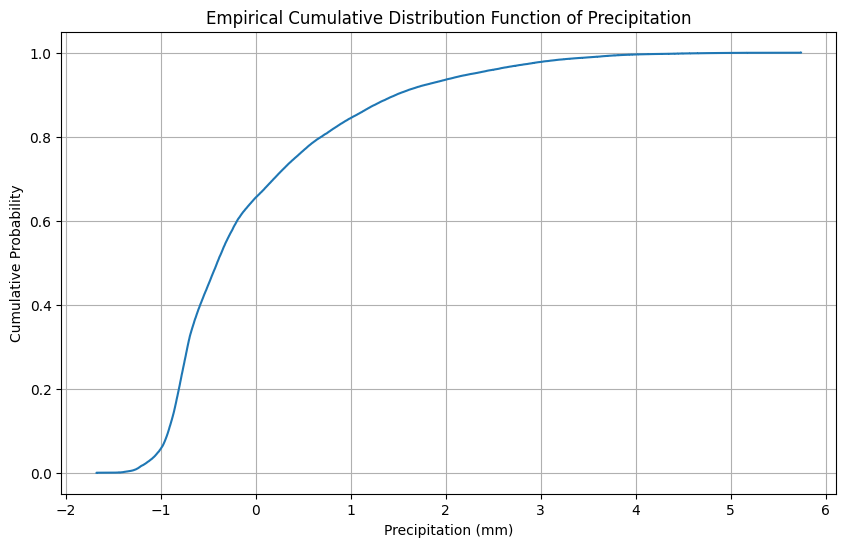

In [520]:
plt.figure(figsize=(10, 6))
plt.step(ecdf_precip.x, ecdf_precip.y, where='post')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution Function of Precipitation')
plt.grid(True)
plt.show()


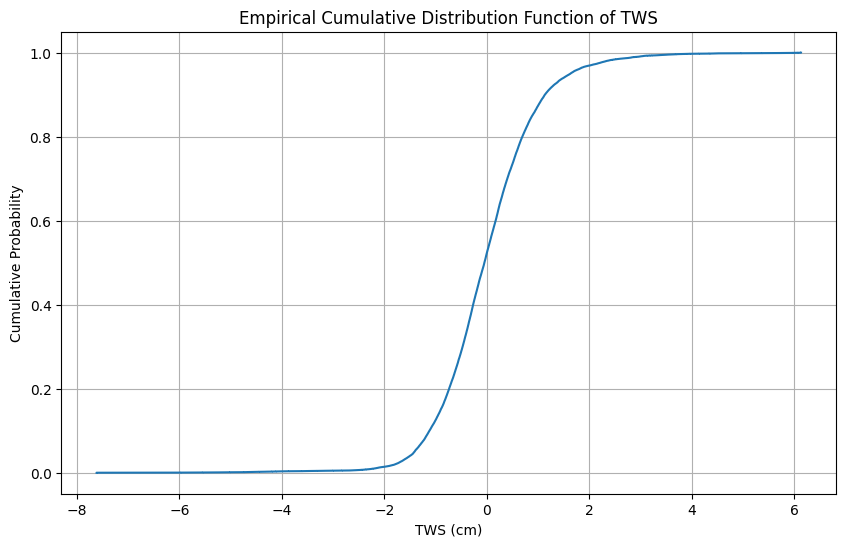

In [521]:
plt.figure(figsize=(10, 6))
plt.step(ecdf_twsa.x, ecdf_twsa.y, where='post')
plt.xlabel('TWS (cm)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution Function of TWS')
plt.grid(True)
plt.show()

In [522]:
len(et_anomaly_1)

75105

#### Transform to uniform margin

In [523]:
# Transform TWSA data
uniform_twsa = ecdf_twsa(tws_anomaly_1)

# Transform Precip data
uniform_precip = ecdf_precip(precip_anomaly_1)

# Transform ET data
uniform_et = ecdf_et(et_anomaly_1)


#### Copula Fitting

In [524]:
# Select subset of the data
uniform_data = np.column_stack([uniform_et[:50000], uniform_precip[:50000], uniform_twsa[:50000]])

In [527]:
# Initialize copulas
copulas = {
 # Archimidean Copulas
    "Frank": FrankCopula(dim=3),
    "Clayton": ClaytonCopula(dim=3),
    "Gumbel": GumbelCopula(dim=3),
    
 # Elliptical Copulas
    "Gaussian": GaussianCopula(dim=3), 
    "t-Copula": StudentCopula(dim=3),
}


In [528]:

results = {}
for name, copula in copulas.items():
    try:
        copula.fit(uniform_data)
        
        # log-likelihood
        log_lik = copula.log_lik(uniform_data)
        
        if name == 't-Copula':
            n_params = copula.params[1].size
        elif name == 'Clayton' or name == 'Gumbel' or name == 'Frank':
            n_params = np.array(copula.params).size
        elif name == 'Gaussian':
            n_params = copula.params.size
        aic = -2 * log_lik + 2 * n_params
        bic = -2 * log_lik + np.log(uniform_data.shape[0]) * n_params
        
        #
        
        results[name] = {"Log-Likelihood": log_lik, "AIC": aic, "BIC": bic, "Parameters": copula.params}
        print(f"{name} Copula: Log-Likelihood={log_lik:.2f}, AIC={aic:.2f}, BIC={bic:.2f}")
    except Exception as e:
        print(f"Error fitting {name} Copula: {e}")

# Step 4: Select the best copula
best_copula_aic = min(results.items(), key=lambda x: x[1]["AIC"])
best_copula_bic = min(results.items(), key=lambda x: x[1]["BIC"])

print("\nBest Copula by AIC:")
print(f"Name: {best_copula_aic[0]}, AIC: {best_copula_aic[1]['AIC']:.2f}, Parameters: {best_copula_aic[1]['Parameters']}")
print("Best Copula by BIC:")
print(f"Name: {best_copula_bic[0]}, BIC: {best_copula_bic[1]['BIC']:.2f}, Parameters: {best_copula_bic[1]['Parameters']}")

# Optional: Store the best copula for further use
best_copula_name = best_copula_aic[0]  # or use BIC
best_copula = copulas[best_copula_name]

Error fitting Frank Copula: theta must be positive when dim > 2
Error fitting Clayton Copula: theta must be positive when dim > 2


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


Gumbel Copula: Log-Likelihood=10.60, AIC=-19.20, BIC=-10.38
Gaussian Copula: Log-Likelihood=4.41, AIC=-2.82, BIC=23.64
t-Copula Copula: Log-Likelihood=2.52, AIC=0.95, BIC=27.41

Best Copula by AIC:
Name: Gumbel, AIC: -19.20, Parameters: 1.0035878695394485
Best Copula by BIC:
Name: Gumbel, BIC: -10.38, Parameters: 1.0035878695394485


### Tail

In [534]:
# 2. Kendall’s Tau Correlation
pairs = [('ET', 'Precip'), ('ET', 'TWS'), ('TWS', 'Precip')]
print("\nKendall's Tau Correlations:")
for var1, var2 in pairs:
    tau, p_value = kendalltau(data[var1], data[var2])
    print(f"{var1} vs {var2}: Tau = {tau:.3f}, p-value = {p_value:.3f}")
    # Note: p-value < 0.05 suggests significant dependence



Kendall's Tau Correlations:
ET vs Precip: Tau = 0.035, p-value = 0.000
ET vs TWS: Tau = 0.002, p-value = 0.408
TWS vs Precip: Tau = -0.001, p-value = 0.732


### Validate the Selected Copula


In [537]:
# Simulate new uniform marginals from the copula
simulated_data = best_copula.random(50000)

In [538]:
simulated_data

array([[0.38624495, 0.10474579, 0.72558786],
       [0.26558991, 0.42073881, 0.83157015],
       [0.73933785, 0.02447972, 0.35062747],
       ...,
       [0.57868411, 0.11488229, 0.26180409],
       [0.59244761, 0.74734307, 0.27589665],
       [0.82235782, 0.09058505, 0.31068397]])

In [539]:
# Validate all pairs
pairs = [("ET", "Precip", 0, 1), ("ET", "TWS", 0, 2), ("Precip", "TWS", 1, 2)]
for var1, var2, idx1, idx2 in pairs:
    tau_obs = kendalltau(uniform_data[:, idx1], uniform_data[:, idx2])[0]
    tau_sim = kendalltau(simulated_data[:, idx1], simulated_data[:, idx2])[0]
    print(f"Observed Tau ({var1}-{var2}): {tau_obs:.3f}, Simulated Tau: {tau_sim:.3f}")

Observed Tau (ET-Precip): 0.002, Simulated Tau: 0.000
Observed Tau (ET-TWS): -0.002, Simulated Tau: 0.003
Observed Tau (Precip-TWS): -0.005, Simulated Tau: -0.002


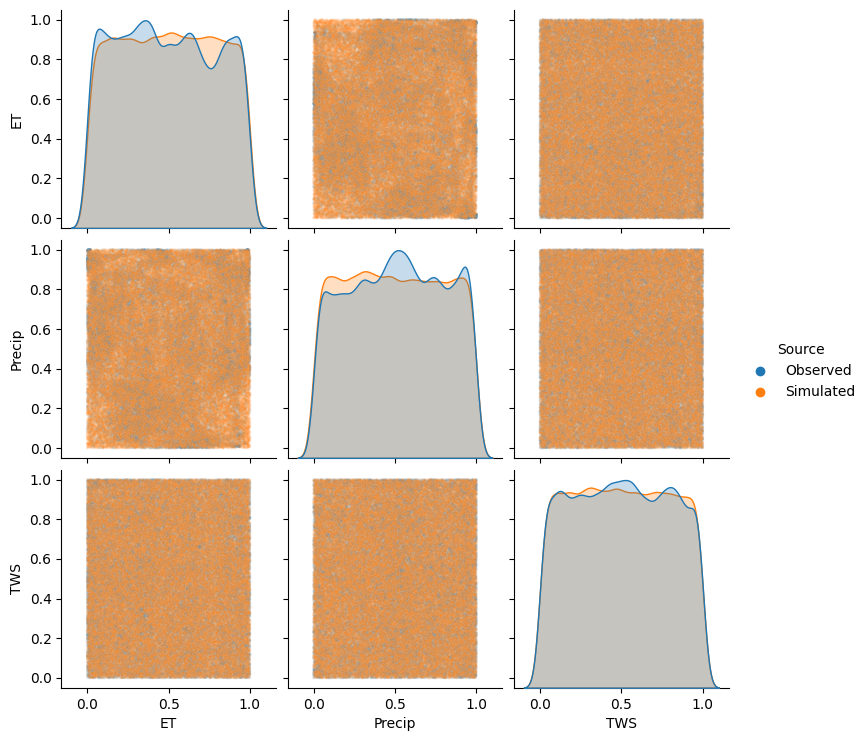

In [540]:
observed_df = pd.DataFrame(uniform_data, columns=["ET", "Precip", "TWS"])
observed_df["Source"] = "Observed"
simulated_df = pd.DataFrame(simulated_data, columns=["ET", "Precip", "TWS"])
simulated_df["Source"] = "Simulated"
combined_df = pd.concat([observed_df.sample(50000, random_state=42), simulated_df])
sns.pairplot(combined_df, hue="Source", diag_kind="kde", plot_kws={"alpha": 0.1, "s": 5})
plt.show()

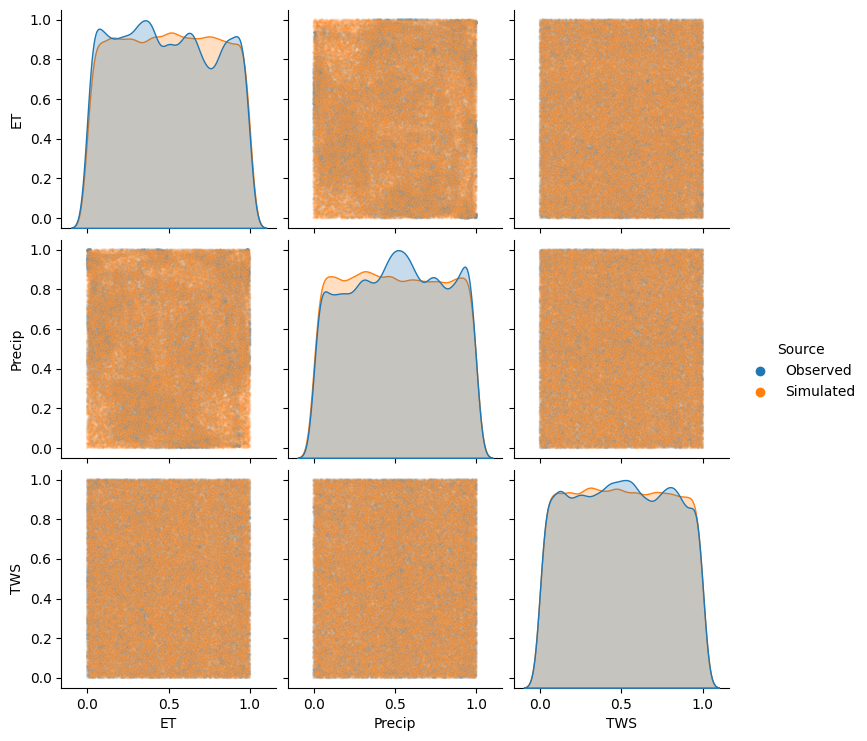

In [541]:
combined_dfn = pd.concat([observed_df[:50000], simulated_df])
sns.pairplot(combined_dfn, hue="Source", diag_kind="kde", plot_kws={"alpha": 0.1, "s": 5})
plt.show()

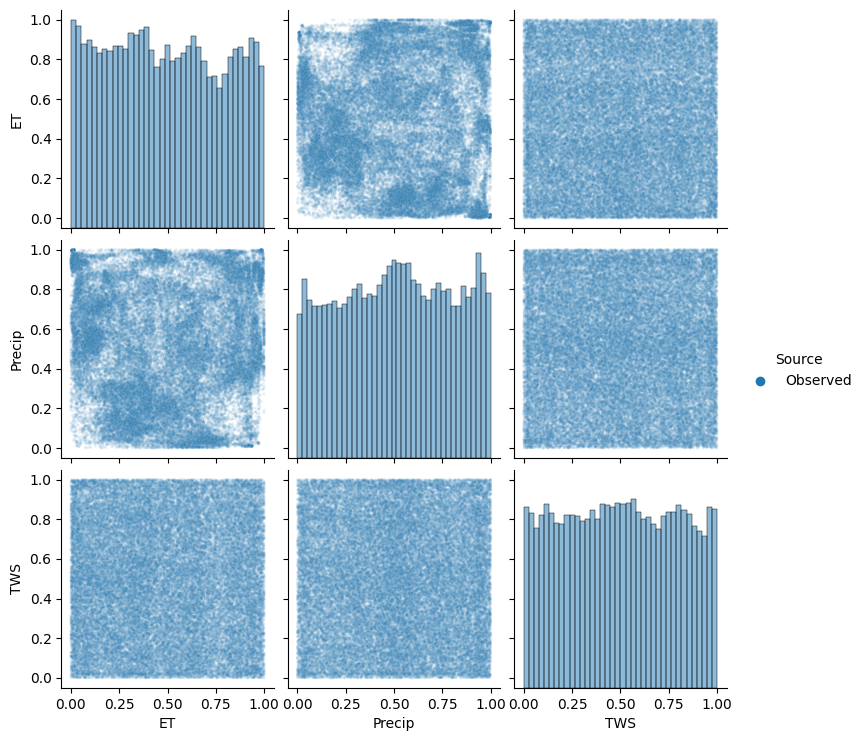

In [630]:
sns.pairplot(observed_df, hue="Source", diag_kind="hist", plot_kws={"alpha": 0.1, "s": 5})
plt.show()

In [ ]:
from scipy.stats import kstest

def goodness_of_fit(copula, data):
    
    theoretical_cdf = best_copula.random(len(data))
    # Perform KS test
    ks_stat, p_value = kstest(data.flatten(), theoretical_cdf.flatten())
    return ks_stat, p_value

# Evaluate each copula
results = {}
for name, copula in copulas.items():
    ks_stat, p_value = goodness_of_fit(copula, uniform_data)
    results[name] = {'KS Statistic': ks_stat, 'p-value': p_value}

# Print results
for name, result in results.items():
    print(f"{name}: KS Statistic = {result['KS Statistic']}, p-value = {result['p-value']}")

Frank: KS Statistic = 0.007939999999999947, p-value = 0.0001555115240863802
Clayton: KS Statistic = 0.008279999999999954, p-value = 6.798257456388977e-05
Gumbel: KS Statistic = 0.008046666666666646, p-value = 0.0001204043365796208
Gaussian: KS Statistic = 0.008479999999999932, p-value = 4.111215696485771e-05
t-Copula: KS Statistic = 0.009359999999999924, p-value = 3.8991580738464906e-06
